In [1]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00


# Emotion Detection - KDEF

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

## Data Engineering

In [3]:
import torch
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/kdef-raf-fer-complete'

# Use x.lower() to access data_transforms, and x directly for directory names
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x.lower()]) # Use x.lower() here
                  for x in ['Train', 'Val']} # 'Train' and 'Val' are the actual directory names

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=4)
               for x in ['Train', 'Val']} # Use 'Train' and 'Val' as keys for dataloaders

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

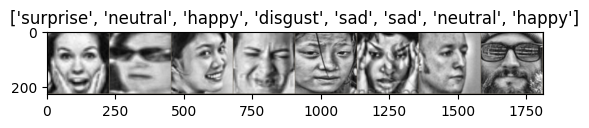

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Development

Now, let's write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch optim.lr_scheduler.

In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/densenet.pt')

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning w/ Covnet

Load a pretrained model and reset final fully connected layer.

In [7]:
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/densenet161_full')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 199MB/s] 


### Model Train and Evaluate

In [8]:
import os
if not os.path.exists('saved'):
    os.makedirs('saved')

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=21)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0/20
----------


100%|██████████| 4392/4392 [15:17<00:00,  4.79it/s]


Train Loss: 1.1632 Acc: 0.5703


100%|██████████| 1061/1061 [01:12<00:00, 14.58it/s]


Val Loss: 0.8823 Acc: 0.6832

Epoch 1/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.76it/s]


Train Loss: 0.8847 Acc: 0.6808


100%|██████████| 1061/1061 [01:12<00:00, 14.54it/s]


Val Loss: 0.8134 Acc: 0.7095

Epoch 2/20
----------


100%|██████████| 4392/4392 [15:22<00:00,  4.76it/s]


Train Loss: 0.7618 Acc: 0.7284


100%|██████████| 1061/1061 [01:13<00:00, 14.49it/s]


Val Loss: 0.8244 Acc: 0.7110

Epoch 3/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.6635 Acc: 0.7659


100%|██████████| 1061/1061 [01:13<00:00, 14.52it/s]


Val Loss: 0.8729 Acc: 0.7028

Epoch 4/20
----------


100%|██████████| 4392/4392 [15:22<00:00,  4.76it/s]


Train Loss: 0.5806 Acc: 0.7948


100%|██████████| 1061/1061 [01:13<00:00, 14.51it/s]


Val Loss: 0.8315 Acc: 0.7238

Epoch 5/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.3681 Acc: 0.8765


100%|██████████| 1061/1061 [01:12<00:00, 14.55it/s]


Val Loss: 0.8009 Acc: 0.7386

Epoch 6/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.2971 Acc: 0.9036


100%|██████████| 1061/1061 [01:12<00:00, 14.55it/s]


Val Loss: 0.8251 Acc: 0.7460

Epoch 7/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.2561 Acc: 0.9182


100%|██████████| 1061/1061 [01:13<00:00, 14.52it/s]


Val Loss: 0.8282 Acc: 0.7455

Epoch 8/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.76it/s]


Train Loss: 0.2201 Acc: 0.9316


100%|██████████| 1061/1061 [01:13<00:00, 14.47it/s]


Val Loss: 0.8477 Acc: 0.7416

Epoch 9/20
----------


100%|██████████| 4392/4392 [15:22<00:00,  4.76it/s]


Train Loss: 0.1931 Acc: 0.9406


100%|██████████| 1061/1061 [01:13<00:00, 14.52it/s]


Val Loss: 0.8952 Acc: 0.7412

Epoch 10/20
----------


100%|██████████| 4392/4392 [15:22<00:00,  4.76it/s]


Train Loss: 0.1679 Acc: 0.9494


100%|██████████| 1061/1061 [01:12<00:00, 14.55it/s]


Val Loss: 0.9148 Acc: 0.7408

Epoch 11/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.76it/s]


Train Loss: 0.1384 Acc: 0.9629


100%|██████████| 1061/1061 [01:13<00:00, 14.52it/s]


Val Loss: 0.9250 Acc: 0.7448

Epoch 12/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1383 Acc: 0.9600


100%|██████████| 1061/1061 [01:13<00:00, 14.53it/s]


Val Loss: 0.9158 Acc: 0.7408

Epoch 13/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1356 Acc: 0.9624


100%|██████████| 1061/1061 [01:13<00:00, 14.53it/s]


Val Loss: 0.9380 Acc: 0.7388

Epoch 14/20
----------


100%|██████████| 4392/4392 [15:20<00:00,  4.77it/s]


Train Loss: 0.1309 Acc: 0.9641


100%|██████████| 1061/1061 [01:13<00:00, 14.53it/s]


Val Loss: 0.9400 Acc: 0.7402

Epoch 15/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1245 Acc: 0.9654


100%|██████████| 1061/1061 [01:12<00:00, 14.55it/s]


Val Loss: 0.9584 Acc: 0.7355

Epoch 16/20
----------


100%|██████████| 4392/4392 [15:20<00:00,  4.77it/s]


Train Loss: 0.1276 Acc: 0.9647


100%|██████████| 1061/1061 [01:13<00:00, 14.51it/s]


Val Loss: 0.9673 Acc: 0.7454

Epoch 17/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1229 Acc: 0.9679


100%|██████████| 1061/1061 [01:13<00:00, 14.53it/s]


Val Loss: 0.9404 Acc: 0.7398

Epoch 18/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1236 Acc: 0.9651


100%|██████████| 1061/1061 [01:13<00:00, 14.52it/s]


Val Loss: 0.9247 Acc: 0.7458

Epoch 19/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1223 Acc: 0.9655


100%|██████████| 1061/1061 [01:13<00:00, 14.53it/s]


Val Loss: 0.9627 Acc: 0.7449

Epoch 20/20
----------


100%|██████████| 4392/4392 [15:21<00:00,  4.77it/s]


Train Loss: 0.1224 Acc: 0.9667


100%|██████████| 1061/1061 [01:13<00:00, 14.49it/s]

Val Loss: 0.9258 Acc: 0.7419

Training complete in 348m 6s
Best Val Acc: 0.745994


## Model Evaluation

In [10]:
model_ft.load_state_dict(torch.load('saved/densenet.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Val']}

In [11]:
import imageio

# --- Define classes dictionary as provided ---
classes = {
    0: "AF",
    1: "AN",
    2: "DI",
    3: "HA",
    4: "NE",
    5: "SA",
    6: "SU"
}

total = 0
correct = 0

# Define the mean and std used for normalization, matching your data_transforms
# These values are crucial for accurate denormalization.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])


for inputs, labels in tqdm(dataloaders['Val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    # Increment total count for each batch (or each image if processing individually)
    # The original code increments total per batch, checking only the first image in the batch.
    # If you want to count per image, you'd need to iterate over the batch's items.
    # For now, sticking to the original logic of checking only the first item per batch for saving.
    total += 1

    # Check only the first image in the batch for correct/incorrect classification
    # and saving
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct += 1
    else:
        # Save the incorrect image
        img = inputs[0].cpu().numpy()

        # Denormalize the image: Reverse the operation (input - mean) / std
        img = img.transpose(1, 2, 0)

        # Apply denormalization: (img * std) + mean
        img = img * IMAGENET_STD + IMAGENET_MEAN

        # Clip values to the valid range [0, 1] in case of floating point inaccuracies
        img = np.clip(img, 0, 1)

        # Scale to 0-255 and convert to uint8
        img = (img * 255).astype(np.uint8)

        # Ensure the array is contiguous for imageio, though it should be after the above steps
        img = np.ascontiguousarray(img)

        # Save the image
        imageio.imwrite(str(total) + '.jpg', img)

        print(f"image no {total}, original class: {classes[int(labels.data[0].cpu().numpy())]}, predicted class: {classes[int(preds.data[0].cpu().numpy())]}")

print(f"Correct: {correct}, Total: {total}")

  0%|          | 7/8488 [00:00<10:32, 13.41it/s]

image no 4, original class: NE, predicted class: DI
image no 9, original class: DI, predicted class: SU


  0%|          | 13/8488 [00:00<07:15, 19.45it/s]

image no 10, original class: AF, predicted class: AN
image no 11, original class: SU, predicted class: SA


  0%|          | 22/8488 [00:01<05:53, 23.94it/s]

image no 17, original class: NE, predicted class: AF
image no 19, original class: HA, predicted class: NE
image no 22, original class: DI, predicted class: NE


  0%|          | 37/8488 [00:01<05:11, 27.15it/s]

image no 34, original class: SA, predicted class: NE


  1%|          | 43/8488 [00:01<05:10, 27.16it/s]

image no 40, original class: SA, predicted class: SU


  1%|          | 55/8488 [00:02<05:10, 27.14it/s]

image no 50, original class: DI, predicted class: SA
image no 54, original class: SA, predicted class: AF


  1%|          | 64/8488 [00:02<05:14, 26.74it/s]

image no 60, original class: HA, predicted class: AN
image no 65, original class: NE, predicted class: SA


  1%|          | 70/8488 [00:02<05:22, 26.14it/s]

image no 67, original class: NE, predicted class: HA
image no 69, original class: AF, predicted class: DI


  1%|          | 91/8488 [00:03<05:09, 27.10it/s]

image no 88, original class: NE, predicted class: HA


  1%|          | 97/8488 [00:03<05:11, 26.96it/s]

image no 94, original class: AF, predicted class: NE
image no 98, original class: SA, predicted class: NE


  1%|          | 106/8488 [00:04<05:21, 26.08it/s]

image no 102, original class: NE, predicted class: AF
image no 103, original class: SA, predicted class: NE
image no 104, original class: SA, predicted class: HA
image no 105, original class: HA, predicted class: SA
image no 107, original class: SA, predicted class: NE


  1%|▏         | 118/8488 [00:04<05:13, 26.68it/s]

image no 113, original class: SA, predicted class: NE
image no 114, original class: DI, predicted class: SA


  1%|▏         | 124/8488 [00:04<05:10, 26.97it/s]

image no 121, original class: AN, predicted class: SA


  2%|▏         | 130/8488 [00:05<05:07, 27.17it/s]

image no 127, original class: NE, predicted class: AF
image no 131, original class: AF, predicted class: NE


  2%|▏         | 139/8488 [00:05<05:15, 26.44it/s]

image no 136, original class: AF, predicted class: SA
image no 137, original class: SU, predicted class: NE
image no 138, original class: SA, predicted class: DI


  2%|▏         | 148/8488 [00:05<05:24, 25.67it/s]

image no 144, original class: NE, predicted class: HA
image no 145, original class: HA, predicted class: SA
image no 146, original class: AF, predicted class: DI
image no 148, original class: SA, predicted class: NE


  2%|▏         | 154/8488 [00:06<05:22, 25.84it/s]

image no 150, original class: AF, predicted class: DI
image no 153, original class: DI, predicted class: SA


  2%|▏         | 160/8488 [00:06<05:26, 25.48it/s]

image no 156, original class: AN, predicted class: NE
image no 158, original class: DI, predicted class: AF
image no 160, original class: NE, predicted class: HA
image no 161, original class: DI, predicted class: SA


  2%|▏         | 169/8488 [00:06<05:23, 25.70it/s]

image no 165, original class: HA, predicted class: NE
image no 167, original class: DI, predicted class: SA
image no 169, original class: DI, predicted class: SU
image no 170, original class: SA, predicted class: DI


  2%|▏         | 184/8488 [00:07<05:13, 26.47it/s]

image no 179, original class: DI, predicted class: SA


  2%|▏         | 196/8488 [00:07<05:07, 26.94it/s]

image no 191, original class: AF, predicted class: SA
image no 196, original class: NE, predicted class: SU


  2%|▏         | 202/8488 [00:07<05:14, 26.31it/s]

image no 197, original class: SU, predicted class: DI
image no 198, original class: DI, predicted class: NE
image no 201, original class: AF, predicted class: NE
image no 202, original class: SA, predicted class: NE


  2%|▏         | 208/8488 [00:08<05:12, 26.53it/s]

image no 203, original class: HA, predicted class: NE
image no 208, original class: AF, predicted class: NE


  3%|▎         | 214/8488 [00:08<05:17, 26.05it/s]

image no 211, original class: NE, predicted class: HA
image no 214, original class: SU, predicted class: DI


  3%|▎         | 223/8488 [00:08<05:11, 26.51it/s]

image no 218, original class: HA, predicted class: NE
image no 219, original class: SA, predicted class: AN


  3%|▎         | 232/8488 [00:09<05:12, 26.38it/s]

image no 228, original class: DI, predicted class: AF
image no 233, original class: AN, predicted class: AF


  3%|▎         | 238/8488 [00:09<05:37, 24.46it/s]

image no 236, original class: DI, predicted class: AF


  3%|▎         | 244/8488 [00:09<05:22, 25.55it/s]

image no 241, original class: HA, predicted class: NE


  3%|▎         | 250/8488 [00:09<05:24, 25.37it/s]

image no 247, original class: SA, predicted class: DI
image no 249, original class: DI, predicted class: SA
image no 250, original class: SA, predicted class: NE
image no 251, original class: HA, predicted class: SA


  3%|▎         | 256/8488 [00:10<05:21, 25.64it/s]

image no 252, original class: SU, predicted class: NE
image no 253, original class: SA, predicted class: DI


  3%|▎         | 271/8488 [00:10<05:03, 27.10it/s]

image no 268, original class: SU, predicted class: DI


  3%|▎         | 277/8488 [00:10<05:01, 27.27it/s]

image no 274, original class: HA, predicted class: NE


  3%|▎         | 283/8488 [00:11<05:11, 26.33it/s]

image no 280, original class: AF, predicted class: NE
image no 281, original class: HA, predicted class: SA
image no 283, original class: AF, predicted class: NE


  3%|▎         | 292/8488 [00:11<05:13, 26.18it/s]

image no 288, original class: NE, predicted class: AF
image no 291, original class: SU, predicted class: NE
image no 293, original class: DI, predicted class: SA


  4%|▎         | 298/8488 [00:11<05:13, 26.11it/s]

image no 294, original class: DI, predicted class: SA
image no 297, original class: SU, predicted class: NE


  4%|▎         | 307/8488 [00:11<05:13, 26.09it/s]

image no 302, original class: SA, predicted class: AN
image no 305, original class: NE, predicted class: SA


  4%|▍         | 322/8488 [00:12<05:02, 26.96it/s]

image no 317, original class: AF, predicted class: DI


  4%|▍         | 331/8488 [00:12<05:04, 26.78it/s]

image no 327, original class: NE, predicted class: SA


  4%|▍         | 343/8488 [00:13<05:06, 26.55it/s]

image no 338, original class: HA, predicted class: NE
image no 339, original class: NE, predicted class: SA


  4%|▍         | 349/8488 [00:13<05:11, 26.11it/s]

image no 345, original class: NE, predicted class: AF
image no 347, original class: NE, predicted class: SU


  4%|▍         | 358/8488 [00:13<05:22, 25.17it/s]

image no 355, original class: HA, predicted class: NE
image no 358, original class: HA, predicted class: NE
image no 360, original class: DI, predicted class: SU


  4%|▍         | 364/8488 [00:14<05:33, 24.40it/s]

image no 361, original class: DI, predicted class: AF
image no 364, original class: SA, predicted class: NE


  4%|▍         | 373/8488 [00:14<05:22, 25.15it/s]

image no 369, original class: DI, predicted class: SU


  5%|▍         | 382/8488 [00:14<05:22, 25.11it/s]

image no 378, original class: NE, predicted class: SA
image no 380, original class: SA, predicted class: AN


  5%|▍         | 391/8488 [00:15<05:20, 25.25it/s]

image no 387, original class: SA, predicted class: NE
image no 389, original class: SU, predicted class: DI


  5%|▍         | 397/8488 [00:15<05:16, 25.60it/s]

image no 393, original class: SA, predicted class: AF
image no 395, original class: DI, predicted class: SU


  5%|▍         | 403/8488 [00:15<05:15, 25.66it/s]

image no 400, original class: SA, predicted class: DI
image no 402, original class: SU, predicted class: DI


  5%|▍         | 409/8488 [00:15<05:09, 26.07it/s]

image no 406, original class: AN, predicted class: HA
image no 410, original class: NE, predicted class: SA


  5%|▍         | 418/8488 [00:16<05:16, 25.53it/s]

image no 415, original class: SA, predicted class: DI
image no 416, original class: NE, predicted class: HA
image no 419, original class: AF, predicted class: DI


  5%|▌         | 427/8488 [00:16<05:21, 25.09it/s]

image no 422, original class: AF, predicted class: SA
image no 425, original class: NE, predicted class: HA
image no 427, original class: AF, predicted class: SA


  5%|▌         | 433/8488 [00:16<05:09, 26.01it/s]

image no 428, original class: AF, predicted class: DI
image no 433, original class: DI, predicted class: SA


  5%|▌         | 442/8488 [00:17<05:10, 25.92it/s]

image no 437, original class: SA, predicted class: NE
image no 438, original class: SU, predicted class: DI


  5%|▌         | 448/8488 [00:17<05:16, 25.44it/s]

image no 444, original class: DI, predicted class: SA
image no 445, original class: SU, predicted class: AF
image no 446, original class: NE, predicted class: SA
image no 448, original class: SA, predicted class: AF


  5%|▌         | 460/8488 [00:17<05:11, 25.76it/s]

image no 457, original class: AN, predicted class: AF
image no 458, original class: NE, predicted class: HA
image no 459, original class: DI, predicted class: SA


  6%|▌         | 469/8488 [00:18<05:06, 26.20it/s]

image no 464, original class: NE, predicted class: AF
image no 469, original class: NE, predicted class: DI


  6%|▌         | 475/8488 [00:18<05:17, 25.27it/s]

image no 473, original class: SA, predicted class: NE
image no 474, original class: SA, predicted class: AF
image no 475, original class: AN, predicted class: SA
image no 476, original class: DI, predicted class: NE


  6%|▌         | 487/8488 [00:18<05:05, 26.17it/s]

image no 483, original class: DI, predicted class: NE


  6%|▌         | 493/8488 [00:19<05:05, 26.15it/s]

image no 490, original class: DI, predicted class: NE


  6%|▌         | 502/8488 [00:19<05:15, 25.34it/s]

image no 497, original class: DI, predicted class: AF
image no 499, original class: SU, predicted class: DI


  6%|▌         | 508/8488 [00:19<05:13, 25.45it/s]

image no 504, original class: HA, predicted class: AF
image no 506, original class: AN, predicted class: SA
image no 508, original class: SA, predicted class: NE
image no 509, original class: NE, predicted class: SA


  6%|▌         | 514/8488 [00:20<05:12, 25.50it/s]

image no 511, original class: DI, predicted class: AF
image no 512, original class: SU, predicted class: DI
image no 513, original class: SA, predicted class: NE


  6%|▋         | 532/8488 [00:20<05:08, 25.80it/s]

image no 529, original class: NE, predicted class: DI
image no 530, original class: DI, predicted class: SA
image no 531, original class: NE, predicted class: AN
image no 532, original class: DI, predicted class: NE


  6%|▋         | 538/8488 [00:20<05:04, 26.07it/s]

image no 535, original class: HA, predicted class: NE
image no 538, original class: SA, predicted class: NE


  6%|▋         | 547/8488 [00:21<05:02, 26.26it/s]

image no 543, original class: DI, predicted class: SU
image no 545, original class: SA, predicted class: NE
image no 546, original class: NE, predicted class: SA


  7%|▋         | 553/8488 [00:21<05:03, 26.15it/s]

image no 550, original class: HA, predicted class: NE
image no 552, original class: DI, predicted class: NE
image no 554, original class: NE, predicted class: AF
image no 555, original class: HA, predicted class: NE


  7%|▋         | 565/8488 [00:21<04:52, 27.06it/s]

image no 561, original class: SU, predicted class: DI
image no 563, original class: SA, predicted class: NE
image no 566, original class: DI, predicted class: SA


  7%|▋         | 571/8488 [00:22<04:54, 26.88it/s]

image no 567, original class: AF, predicted class: DI
image no 572, original class: AF, predicted class: DI


  7%|▋         | 580/8488 [00:22<04:58, 26.47it/s]

image no 577, original class: SU, predicted class: SA
image no 580, original class: SA, predicted class: AN
image no 582, original class: NE, predicted class: SA


  7%|▋         | 586/8488 [00:22<04:59, 26.40it/s]

image no 583, original class: DI, predicted class: NE
image no 587, original class: DI, predicted class: SA


  7%|▋         | 601/8488 [00:23<05:00, 26.23it/s]

image no 598, original class: DI, predicted class: SA
image no 601, original class: AN, predicted class: AF


  7%|▋         | 607/8488 [00:23<05:02, 26.07it/s]

image no 604, original class: NE, predicted class: SU
image no 608, original class: NE, predicted class: SU
image no 609, original class: AN, predicted class: AF


  7%|▋         | 613/8488 [00:23<05:01, 26.14it/s]

image no 610, original class: NE, predicted class: SA
image no 615, original class: SA, predicted class: AF


  7%|▋         | 622/8488 [00:24<04:55, 26.62it/s]

image no 617, original class: DI, predicted class: NE


  7%|▋         | 628/8488 [00:24<05:00, 26.15it/s]

image no 625, original class: SA, predicted class: NE
image no 627, original class: AF, predicted class: SA
image no 630, original class: DI, predicted class: SA


  7%|▋         | 634/8488 [00:24<05:02, 26.00it/s]

image no 631, original class: NE, predicted class: AF
image no 632, original class: SA, predicted class: NE


  8%|▊         | 643/8488 [00:24<04:56, 26.45it/s]

image no 640, original class: NE, predicted class: HA
image no 641, original class: DI, predicted class: SU


  8%|▊         | 658/8488 [00:25<04:59, 26.17it/s]

image no 654, original class: AN, predicted class: HA
image no 655, original class: SU, predicted class: AF
image no 656, original class: AN, predicted class: AF


  8%|▊         | 664/8488 [00:25<05:06, 25.53it/s]

image no 660, original class: AF, predicted class: SA
image no 661, original class: NE, predicted class: SA
image no 662, original class: NE, predicted class: AF


  8%|▊         | 670/8488 [00:25<05:02, 25.81it/s]

image no 665, original class: SA, predicted class: NE
image no 670, original class: NE, predicted class: HA


  8%|▊         | 679/8488 [00:26<04:59, 26.03it/s]

image no 676, original class: SA, predicted class: NE
image no 679, original class: NE, predicted class: SA
image no 680, original class: SU, predicted class: HA


  8%|▊         | 700/8488 [00:27<04:46, 27.15it/s]

image no 696, original class: NE, predicted class: AN


  8%|▊         | 712/8488 [00:27<04:48, 26.97it/s]

image no 708, original class: HA, predicted class: NE
image no 712, original class: SA, predicted class: AF


  8%|▊         | 718/8488 [00:27<04:50, 26.74it/s]

image no 714, original class: NE, predicted class: HA
image no 716, original class: NE, predicted class: SA


  9%|▊         | 724/8488 [00:27<04:49, 26.80it/s]

image no 720, original class: HA, predicted class: AF
image no 721, original class: SA, predicted class: NE
image no 725, original class: DI, predicted class: SA


  9%|▊         | 730/8488 [00:28<04:59, 25.92it/s]

image no 727, original class: DI, predicted class: AF
image no 728, original class: SU, predicted class: NE
image no 730, original class: SU, predicted class: DI


  9%|▉         | 745/8488 [00:28<04:42, 27.44it/s]

image no 742, original class: NE, predicted class: DI
image no 747, original class: NE, predicted class: SA


  9%|▉         | 754/8488 [00:29<04:56, 26.11it/s]

image no 749, original class: HA, predicted class: AF
image no 750, original class: DI, predicted class: NE


  9%|▉         | 772/8488 [00:29<04:52, 26.35it/s]

image no 767, original class: NE, predicted class: SU
image no 769, original class: AF, predicted class: SU
image no 771, original class: SU, predicted class: DI


  9%|▉         | 778/8488 [00:30<04:55, 26.11it/s]

image no 773, original class: NE, predicted class: AN
image no 776, original class: SA, predicted class: DI
image no 777, original class: NE, predicted class: SA


  9%|▉         | 784/8488 [00:30<05:00, 25.60it/s]

image no 779, original class: HA, predicted class: NE
image no 783, original class: HA, predicted class: SU


  9%|▉         | 790/8488 [00:30<04:53, 26.22it/s]

image no 785, original class: DI, predicted class: SA


  9%|▉         | 796/8488 [00:30<04:54, 26.08it/s]

image no 793, original class: AF, predicted class: AN


 10%|▉         | 808/8488 [00:31<04:55, 25.99it/s]

image no 803, original class: HA, predicted class: AF
image no 804, original class: HA, predicted class: NE


 10%|▉         | 814/8488 [00:31<04:57, 25.76it/s]

image no 809, original class: DI, predicted class: NE
image no 813, original class: HA, predicted class: NE
image no 814, original class: SA, predicted class: NE


 10%|▉         | 820/8488 [00:31<04:58, 25.65it/s]

image no 817, original class: AF, predicted class: NE
image no 818, original class: SU, predicted class: AF
image no 822, original class: NE, predicted class: SA


 10%|▉         | 829/8488 [00:31<04:48, 26.54it/s]

image no 826, original class: NE, predicted class: SA


 10%|▉         | 835/8488 [00:32<04:53, 26.03it/s]

image no 832, original class: HA, predicted class: SA
image no 834, original class: DI, predicted class: SU
image no 836, original class: DI, predicted class: SU


 10%|▉         | 841/8488 [00:32<04:50, 26.31it/s]

image no 837, original class: SA, predicted class: NE
image no 842, original class: DI, predicted class: NE


 10%|█         | 850/8488 [00:32<04:51, 26.20it/s]

image no 845, original class: NE, predicted class: SA
image no 847, original class: AF, predicted class: AN
image no 850, original class: NE, predicted class: DI


 10%|█         | 856/8488 [00:33<04:52, 26.09it/s]

image no 852, original class: DI, predicted class: NE
image no 856, original class: AN, predicted class: DI
image no 857, original class: SA, predicted class: DI


 10%|█         | 862/8488 [00:33<04:59, 25.44it/s]

image no 858, original class: NE, predicted class: SA
image no 860, original class: SA, predicted class: NE
image no 862, original class: AF, predicted class: NE


 10%|█         | 868/8488 [00:33<05:01, 25.28it/s]

image no 864, original class: AF, predicted class: AN
image no 865, original class: HA, predicted class: NE
image no 866, original class: DI, predicted class: SU
image no 867, original class: SA, predicted class: SU


 10%|█         | 874/8488 [00:33<05:02, 25.16it/s]

image no 869, original class: AF, predicted class: NE
image no 872, original class: DI, predicted class: SU
image no 873, original class: SA, predicted class: NE


 10%|█         | 880/8488 [00:33<04:59, 25.44it/s]

image no 875, original class: NE, predicted class: HA
image no 876, original class: NE, predicted class: SA
image no 879, original class: DI, predicted class: SA


 10%|█         | 889/8488 [00:34<04:54, 25.81it/s]

image no 885, original class: DI, predicted class: SA


 11%|█         | 898/8488 [00:34<04:53, 25.83it/s]

image no 893, original class: DI, predicted class: SA
image no 894, original class: NE, predicted class: AF
image no 895, original class: SA, predicted class: AF


 11%|█         | 907/8488 [00:34<04:41, 26.90it/s]

image no 902, original class: NE, predicted class: HA


 11%|█         | 916/8488 [00:35<04:39, 27.12it/s]

image no 912, original class: SU, predicted class: DI


 11%|█         | 922/8488 [00:35<04:45, 26.53it/s]

image no 919, original class: HA, predicted class: NE
image no 923, original class: DI, predicted class: SA


 11%|█         | 934/8488 [00:36<04:52, 25.84it/s]

image no 929, original class: NE, predicted class: SA


 11%|█         | 940/8488 [00:36<04:52, 25.84it/s]

image no 935, original class: SU, predicted class: AF
image no 936, original class: SA, predicted class: NE


 11%|█         | 949/8488 [00:36<04:50, 25.91it/s]

image no 946, original class: SA, predicted class: NE
image no 947, original class: SU, predicted class: DI
image no 949, original class: NE, predicted class: SA


 11%|█▏        | 964/8488 [00:37<04:48, 26.11it/s]

image no 960, original class: HA, predicted class: SU
image no 961, original class: DI, predicted class: HA
image no 963, original class: DI, predicted class: SA
image no 964, original class: NE, predicted class: AF


 11%|█▏        | 970/8488 [00:37<04:46, 26.21it/s]

image no 966, original class: HA, predicted class: AF
image no 969, original class: NE, predicted class: SU


 11%|█▏        | 976/8488 [00:37<04:43, 26.50it/s]

image no 973, original class: SU, predicted class: DI
image no 975, original class: SU, predicted class: NE
image no 977, original class: NE, predicted class: SA


 12%|█▏        | 982/8488 [00:37<04:42, 26.59it/s]

image no 979, original class: DI, predicted class: SU


 12%|█▏        | 991/8488 [00:38<04:40, 26.77it/s]

image no 988, original class: AF, predicted class: NE


 12%|█▏        | 997/8488 [00:38<04:41, 26.57it/s]

image no 994, original class: SA, predicted class: NE
image no 997, original class: HA, predicted class: SA


 12%|█▏        | 1003/8488 [00:38<04:41, 26.58it/s]

image no 1000, original class: DI, predicted class: SA
image no 1003, original class: NE, predicted class: SA


 12%|█▏        | 1018/8488 [00:39<04:42, 26.42it/s]

image no 1014, original class: NE, predicted class: HA


 12%|█▏        | 1030/8488 [00:39<04:49, 25.74it/s]

image no 1025, original class: DI, predicted class: AF
image no 1026, original class: DI, predicted class: HA
image no 1027, original class: NE, predicted class: SU
image no 1029, original class: SU, predicted class: DI


 12%|█▏        | 1039/8488 [00:40<04:34, 27.12it/s]

image no 1034, original class: NE, predicted class: SA


 12%|█▏        | 1048/8488 [00:40<04:40, 26.48it/s]

image no 1045, original class: SA, predicted class: NE
image no 1047, original class: NE, predicted class: SU


 12%|█▏        | 1057/8488 [00:40<04:38, 26.69it/s]

image no 1053, original class: SA, predicted class: NE


 13%|█▎        | 1063/8488 [00:40<04:33, 27.14it/s]

image no 1059, original class: DI, predicted class: SA
image no 1064, original class: AF, predicted class: SA


 13%|█▎        | 1069/8488 [00:41<04:40, 26.41it/s]

image no 1065, original class: AF, predicted class: NE
image no 1069, original class: HA, predicted class: DI


 13%|█▎        | 1078/8488 [00:41<04:30, 27.38it/s]

image no 1073, original class: SA, predicted class: AF


 13%|█▎        | 1090/8488 [00:41<04:32, 27.17it/s]

image no 1085, original class: SA, predicted class: NE
image no 1088, original class: HA, predicted class: SU
image no 1090, original class: DI, predicted class: SA


 13%|█▎        | 1096/8488 [00:42<04:43, 26.09it/s]

image no 1093, original class: AF, predicted class: HA
image no 1094, original class: NE, predicted class: SA
image no 1095, original class: NE, predicted class: HA


 13%|█▎        | 1105/8488 [00:42<04:42, 26.10it/s]

image no 1102, original class: AF, predicted class: SA
image no 1103, original class: NE, predicted class: DI
image no 1105, original class: DI, predicted class: AN
image no 1106, original class: SA, predicted class: AF


 13%|█▎        | 1114/8488 [00:42<04:45, 25.79it/s]

image no 1109, original class: AF, predicted class: SA
image no 1112, original class: DI, predicted class: SU
image no 1113, original class: NE, predicted class: SA
image no 1114, original class: SA, predicted class: HA


 13%|█▎        | 1141/8488 [00:43<04:35, 26.66it/s]

image no 1137, original class: AF, predicted class: NE
image no 1140, original class: NE, predicted class: HA
image no 1141, original class: SA, predicted class: NE


 14%|█▎        | 1147/8488 [00:44<04:34, 26.72it/s]

image no 1143, original class: AF, predicted class: NE


 14%|█▎        | 1156/8488 [00:44<04:29, 27.25it/s]

image no 1152, original class: DI, predicted class: SA


 14%|█▎        | 1162/8488 [00:44<04:29, 27.23it/s]

image no 1158, original class: SU, predicted class: NE
image no 1162, original class: AN, predicted class: NE


 14%|█▍        | 1168/8488 [00:44<04:36, 26.50it/s]

image no 1164, original class: SA, predicted class: NE
image no 1166, original class: SA, predicted class: NE


 14%|█▍        | 1195/8488 [00:45<05:02, 24.10it/s]

image no 1192, original class: DI, predicted class: SA
image no 1193, original class: DI, predicted class: SA


 14%|█▍        | 1207/8488 [00:46<04:51, 24.94it/s]

image no 1204, original class: NE, predicted class: HA
image no 1207, original class: HA, predicted class: SA


 14%|█▍        | 1216/8488 [00:46<04:50, 25.02it/s]

image no 1211, original class: SA, predicted class: AF


 14%|█▍        | 1222/8488 [00:47<04:52, 24.86it/s]

image no 1218, original class: SA, predicted class: AF
image no 1221, original class: DI, predicted class: AN
image no 1222, original class: SA, predicted class: AF


 14%|█▍        | 1228/8488 [00:47<04:45, 25.41it/s]

image no 1225, original class: HA, predicted class: NE
image no 1230, original class: NE, predicted class: SU


 15%|█▍        | 1240/8488 [00:47<04:35, 26.35it/s]

image no 1235, original class: SA, predicted class: AF


 15%|█▍        | 1246/8488 [00:47<04:35, 26.32it/s]

image no 1243, original class: SU, predicted class: NE
image no 1246, original class: SA, predicted class: SU
image no 1247, original class: NE, predicted class: SA
image no 1248, original class: AF, predicted class: DI


 15%|█▍        | 1255/8488 [00:48<04:36, 26.13it/s]

image no 1251, original class: AF, predicted class: AN
image no 1252, original class: DI, predicted class: SU
image no 1255, original class: SA, predicted class: NE
image no 1256, original class: SA, predicted class: NE


 15%|█▍        | 1264/8488 [00:48<04:34, 26.29it/s]

image no 1259, original class: AF, predicted class: NE
image no 1264, original class: HA, predicted class: SU


 15%|█▍        | 1270/8488 [00:48<04:31, 26.60it/s]

image no 1267, original class: SA, predicted class: NE
image no 1270, original class: NE, predicted class: HA


 15%|█▌        | 1279/8488 [00:49<04:38, 25.84it/s]

image no 1275, original class: NE, predicted class: HA
image no 1277, original class: DI, predicted class: SU
image no 1278, original class: NE, predicted class: SA
image no 1279, original class: DI, predicted class: AF


 15%|█▌        | 1285/8488 [00:49<04:54, 24.49it/s]

image no 1282, original class: NE, predicted class: AF
image no 1283, original class: SA, predicted class: DI
image no 1285, original class: NE, predicted class: SA


 15%|█▌        | 1300/8488 [00:49<04:29, 26.67it/s]

image no 1296, original class: NE, predicted class: HA
image no 1297, original class: NE, predicted class: SU
image no 1301, original class: AF, predicted class: HA


 15%|█▌        | 1315/8488 [00:50<04:28, 26.76it/s]

image no 1311, original class: AN, predicted class: AF
image no 1313, original class: SA, predicted class: NE


 16%|█▌        | 1321/8488 [00:50<04:35, 26.05it/s]

image no 1318, original class: HA, predicted class: SA
image no 1319, original class: HA, predicted class: SU
image no 1320, original class: AF, predicted class: DI


 16%|█▌        | 1327/8488 [00:51<04:37, 25.82it/s]

image no 1324, original class: DI, predicted class: AF
image no 1327, original class: DI, predicted class: AF


 16%|█▌        | 1336/8488 [00:51<04:32, 26.25it/s]

image no 1331, original class: DI, predicted class: AF
image no 1332, original class: DI, predicted class: SA


 16%|█▌        | 1345/8488 [00:51<04:26, 26.83it/s]

image no 1340, original class: DI, predicted class: AF


 16%|█▌        | 1351/8488 [00:51<04:27, 26.66it/s]

image no 1347, original class: AN, predicted class: NE
image no 1348, original class: SA, predicted class: HA
image no 1351, original class: DI, predicted class: AF


 16%|█▌        | 1357/8488 [00:52<04:27, 26.69it/s]

image no 1353, original class: NE, predicted class: SU


 16%|█▌        | 1366/8488 [00:52<04:25, 26.78it/s]

image no 1362, original class: HA, predicted class: DI
image no 1363, original class: SA, predicted class: AF
image no 1365, original class: SA, predicted class: DI


 16%|█▋        | 1381/8488 [00:53<04:24, 26.86it/s]

image no 1378, original class: SU, predicted class: DI
image no 1381, original class: HA, predicted class: AN


 16%|█▋        | 1390/8488 [00:53<04:22, 27.05it/s]

image no 1385, original class: AF, predicted class: NE
image no 1388, original class: DI, predicted class: HA


 17%|█▋        | 1411/8488 [00:54<04:22, 26.97it/s]

image no 1407, original class: SA, predicted class: NE
image no 1408, original class: AF, predicted class: SA


 17%|█▋        | 1426/8488 [00:54<04:34, 25.70it/s]

image no 1424, original class: NE, predicted class: HA
image no 1425, original class: NE, predicted class: SU
image no 1426, original class: SU, predicted class: SA
image no 1428, original class: NE, predicted class: SU


 17%|█▋        | 1432/8488 [00:54<04:35, 25.60it/s]

image no 1429, original class: AF, predicted class: NE
image no 1432, original class: HA, predicted class: SA


 17%|█▋        | 1444/8488 [00:55<04:24, 26.59it/s]

image no 1440, original class: AF, predicted class: NE
image no 1445, original class: AF, predicted class: SA


 17%|█▋        | 1462/8488 [00:56<04:21, 26.90it/s]

image no 1459, original class: NE, predicted class: SA
image no 1460, original class: SU, predicted class: DI
image no 1463, original class: SA, predicted class: NE


 17%|█▋        | 1471/8488 [00:56<04:22, 26.73it/s]

image no 1467, original class: AF, predicted class: NE


 17%|█▋        | 1480/8488 [00:56<04:22, 26.68it/s]

image no 1475, original class: DI, predicted class: SA


 18%|█▊        | 1486/8488 [00:56<04:27, 26.16it/s]

image no 1481, original class: NE, predicted class: DI
image no 1484, original class: DI, predicted class: SA
image no 1485, original class: AF, predicted class: NE


 18%|█▊        | 1492/8488 [00:57<04:28, 26.09it/s]

image no 1488, original class: SA, predicted class: AF
image no 1491, original class: DI, predicted class: NE


 18%|█▊        | 1498/8488 [00:57<04:26, 26.26it/s]

image no 1494, original class: SA, predicted class: HA
image no 1498, original class: AF, predicted class: NE


 18%|█▊        | 1507/8488 [00:57<04:14, 27.39it/s]

image no 1503, original class: AF, predicted class: DI
image no 1504, original class: SA, predicted class: AF


 18%|█▊        | 1513/8488 [00:57<04:23, 26.50it/s]

image no 1509, original class: AN, predicted class: DI
image no 1510, original class: DI, predicted class: SA
image no 1511, original class: AF, predicted class: SA
image no 1513, original class: AN, predicted class: NE


 18%|█▊        | 1522/8488 [00:58<04:23, 26.43it/s]

image no 1517, original class: AF, predicted class: DI
image no 1520, original class: NE, predicted class: AF
image no 1522, original class: NE, predicted class: AF


 18%|█▊        | 1531/8488 [00:58<04:17, 27.02it/s]

image no 1527, original class: SU, predicted class: DI
image no 1529, original class: SA, predicted class: DI


 18%|█▊        | 1540/8488 [00:58<04:15, 27.22it/s]

image no 1537, original class: SU, predicted class: DI
image no 1538, original class: AF, predicted class: SA
image no 1542, original class: NE, predicted class: AN


 18%|█▊        | 1549/8488 [00:59<04:39, 24.84it/s]

image no 1545, original class: NE, predicted class: AN
image no 1549, original class: SU, predicted class: NE


 18%|█▊        | 1564/8488 [00:59<04:20, 26.54it/s]

image no 1561, original class: SA, predicted class: DI
image no 1562, original class: AF, predicted class: SA


 19%|█▊        | 1573/8488 [01:00<04:17, 26.82it/s]

image no 1568, original class: HA, predicted class: NE


 19%|█▊        | 1579/8488 [01:00<04:16, 26.99it/s]

image no 1576, original class: SU, predicted class: SA


 19%|█▊        | 1588/8488 [01:00<04:15, 27.05it/s]

image no 1583, original class: NE, predicted class: SA
image no 1585, original class: SU, predicted class: HA


 19%|█▉        | 1609/8488 [01:01<04:13, 27.15it/s]

image no 1605, original class: NE, predicted class: DI
image no 1610, original class: DI, predicted class: NE


 19%|█▉        | 1621/8488 [01:01<04:13, 27.11it/s]

image no 1618, original class: DI, predicted class: NE


 19%|█▉        | 1630/8488 [01:02<04:12, 27.17it/s]

image no 1625, original class: NE, predicted class: SA


 19%|█▉        | 1636/8488 [01:02<04:11, 27.19it/s]

image no 1631, original class: NE, predicted class: HA
image no 1635, original class: NE, predicted class: SA


 19%|█▉        | 1651/8488 [01:03<04:20, 26.27it/s]

image no 1647, original class: AF, predicted class: HA
image no 1649, original class: AF, predicted class: NE
image no 1650, original class: NE, predicted class: DI


 20%|█▉        | 1657/8488 [01:03<04:22, 26.01it/s]

image no 1653, original class: AN, predicted class: SA
image no 1656, original class: HA, predicted class: AN


 20%|█▉        | 1663/8488 [01:03<04:26, 25.64it/s]

image no 1659, original class: SU, predicted class: DI
image no 1661, original class: AF, predicted class: HA
image no 1663, original class: AN, predicted class: NE
image no 1664, original class: SU, predicted class: AN


 20%|█▉        | 1672/8488 [01:03<04:18, 26.37it/s]

image no 1669, original class: SA, predicted class: NE
image no 1672, original class: HA, predicted class: SA


 20%|█▉        | 1684/8488 [01:04<04:15, 26.65it/s]

image no 1681, original class: NE, predicted class: HA
image no 1686, original class: SA, predicted class: HA


 20%|█▉        | 1693/8488 [01:04<04:15, 26.59it/s]

image no 1688, original class: DI, predicted class: AF
image no 1689, original class: NE, predicted class: HA


 20%|██        | 1699/8488 [01:04<04:13, 26.83it/s]

image no 1695, original class: SA, predicted class: DI
image no 1699, original class: SA, predicted class: AF
image no 1700, original class: AF, predicted class: SA


 20%|██        | 1711/8488 [01:05<04:20, 26.06it/s]

image no 1707, original class: SU, predicted class: HA
image no 1709, original class: SU, predicted class: DI
image no 1711, original class: AF, predicted class: NE


 20%|██        | 1717/8488 [01:05<04:16, 26.41it/s]

image no 1714, original class: DI, predicted class: AF
image no 1719, original class: NE, predicted class: SA


 20%|██        | 1723/8488 [01:05<04:24, 25.62it/s]

image no 1720, original class: AF, predicted class: SA
image no 1722, original class: HA, predicted class: NE
image no 1725, original class: HA, predicted class: NE


 20%|██        | 1729/8488 [01:06<04:19, 26.03it/s]

image no 1726, original class: SA, predicted class: DI
image no 1727, original class: HA, predicted class: NE


 21%|██        | 1741/8488 [01:06<04:19, 25.99it/s]

image no 1736, original class: HA, predicted class: NE
image no 1738, original class: SA, predicted class: HA


 21%|██        | 1747/8488 [01:06<04:24, 25.46it/s]

image no 1744, original class: DI, predicted class: AF
image no 1746, original class: DI, predicted class: SA
image no 1747, original class: DI, predicted class: SA


 21%|██        | 1753/8488 [01:07<04:24, 25.42it/s]

image no 1750, original class: DI, predicted class: SA
image no 1752, original class: NE, predicted class: SA


 21%|██        | 1762/8488 [01:07<04:20, 25.83it/s]

image no 1759, original class: AF, predicted class: NE
image no 1761, original class: SU, predicted class: NE
image no 1763, original class: DI, predicted class: SA


 21%|██        | 1768/8488 [01:07<04:19, 25.90it/s]

image no 1765, original class: SA, predicted class: AF
image no 1767, original class: SA, predicted class: AF


 21%|██        | 1774/8488 [01:07<04:16, 26.17it/s]

image no 1771, original class: AF, predicted class: SA
image no 1776, original class: HA, predicted class: SU


 21%|██        | 1783/8488 [01:08<04:20, 25.78it/s]

image no 1778, original class: NE, predicted class: DI
image no 1782, original class: AF, predicted class: SU


 21%|██        | 1789/8488 [01:08<04:20, 25.75it/s]

image no 1786, original class: SU, predicted class: SA


 21%|██        | 1798/8488 [01:08<04:16, 26.09it/s]

image no 1793, original class: NE, predicted class: AN


 21%|██▏       | 1807/8488 [01:09<04:21, 25.53it/s]

image no 1805, original class: HA, predicted class: AF


 21%|██▏       | 1822/8488 [01:09<04:33, 24.39it/s]

image no 1818, original class: SA, predicted class: NE
image no 1820, original class: SU, predicted class: DI
image no 1821, original class: HA, predicted class: DI


 22%|██▏       | 1828/8488 [01:09<04:28, 24.84it/s]

image no 1823, original class: NE, predicted class: DI
image no 1824, original class: AF, predicted class: DI


 22%|██▏       | 1834/8488 [01:10<04:27, 24.92it/s]

image no 1829, original class: DI, predicted class: SA
image no 1833, original class: NE, predicted class: SA


 22%|██▏       | 1840/8488 [01:10<04:26, 24.94it/s]

image no 1835, original class: AF, predicted class: DI
image no 1840, original class: NE, predicted class: SA


 22%|██▏       | 1846/8488 [01:10<04:28, 24.70it/s]

image no 1843, original class: AF, predicted class: DI


 22%|██▏       | 1858/8488 [01:11<04:26, 24.91it/s]

image no 1856, original class: HA, predicted class: SA
image no 1859, original class: NE, predicted class: SA


 22%|██▏       | 1864/8488 [01:11<04:23, 25.15it/s]

image no 1861, original class: SU, predicted class: AF
image no 1864, original class: SA, predicted class: NE


 22%|██▏       | 1870/8488 [01:11<04:17, 25.67it/s]

image no 1867, original class: DI, predicted class: SA
image no 1871, original class: NE, predicted class: DI


 22%|██▏       | 1885/8488 [01:12<04:17, 25.62it/s]

image no 1881, original class: NE, predicted class: SA


 22%|██▏       | 1894/8488 [01:12<04:22, 25.15it/s]

image no 1890, original class: NE, predicted class: HA
image no 1891, original class: AF, predicted class: DI
image no 1893, original class: NE, predicted class: DI


 22%|██▏       | 1900/8488 [01:12<04:21, 25.22it/s]

image no 1895, original class: SA, predicted class: DI
image no 1897, original class: SA, predicted class: AF
image no 1900, original class: HA, predicted class: NE


 22%|██▏       | 1906/8488 [01:13<04:18, 25.48it/s]

image no 1903, original class: AF, predicted class: SA
image no 1904, original class: SA, predicted class: HA


 23%|██▎       | 1918/8488 [01:13<04:18, 25.44it/s]

image no 1915, original class: SU, predicted class: NE
image no 1916, original class: DI, predicted class: SA
image no 1917, original class: NE, predicted class: SA


 23%|██▎       | 1930/8488 [01:13<04:14, 25.73it/s]

image no 1926, original class: DI, predicted class: NE
image no 1930, original class: SU, predicted class: DI


 23%|██▎       | 1939/8488 [01:14<04:11, 26.04it/s]

image no 1935, original class: DI, predicted class: AF


 23%|██▎       | 1948/8488 [01:14<04:14, 25.74it/s]

image no 1943, original class: DI, predicted class: HA
image no 1945, original class: HA, predicted class: AN
image no 1947, original class: DI, predicted class: SA


 23%|██▎       | 1957/8488 [01:15<04:07, 26.36it/s]

image no 1954, original class: NE, predicted class: SA
image no 1958, original class: NE, predicted class: SA


 23%|██▎       | 1963/8488 [01:15<04:07, 26.37it/s]

image no 1960, original class: DI, predicted class: AF
image no 1964, original class: AF, predicted class: SA


 23%|██▎       | 1969/8488 [01:15<04:05, 26.56it/s]

image no 1966, original class: AF, predicted class: SA
image no 1969, original class: AF, predicted class: SA


 24%|██▎       | 1996/8488 [01:16<04:11, 25.84it/s]

image no 1992, original class: DI, predicted class: SA
image no 1993, original class: SA, predicted class: NE
image no 1994, original class: NE, predicted class: AF
image no 1995, original class: SA, predicted class: NE
image no 1996, original class: HA, predicted class: NE


 24%|██▎       | 2002/8488 [01:16<04:10, 25.85it/s]

image no 1999, original class: HA, predicted class: NE
image no 2002, original class: NE, predicted class: SA
image no 2004, original class: SU, predicted class: SA


 24%|██▎       | 2008/8488 [01:16<04:19, 25.01it/s]

image no 2006, original class: DI, predicted class: SA


 24%|██▎       | 2014/8488 [01:17<04:23, 24.55it/s]

image no 2011, original class: HA, predicted class: AF
image no 2013, original class: AF, predicted class: NE


 24%|██▍       | 2023/8488 [01:17<04:18, 24.96it/s]

image no 2019, original class: SA, predicted class: NE


 24%|██▍       | 2032/8488 [01:17<04:14, 25.36it/s]

image no 2027, original class: SA, predicted class: NE
image no 2029, original class: HA, predicted class: NE
image no 2030, original class: SA, predicted class: AF


 24%|██▍       | 2038/8488 [01:18<04:12, 25.56it/s]

image no 2033, original class: DI, predicted class: AF


 24%|██▍       | 2068/8488 [01:19<04:20, 24.63it/s]

image no 2064, original class: NE, predicted class: HA
image no 2066, original class: SA, predicted class: NE
image no 2068, original class: AF, predicted class: SA


 24%|██▍       | 2077/8488 [01:19<04:07, 25.88it/s]

image no 2074, original class: DI, predicted class: SA
image no 2077, original class: SA, predicted class: DI


 25%|██▍       | 2086/8488 [01:19<04:05, 26.12it/s]

image no 2081, original class: DI, predicted class: SU
image no 2085, original class: AF, predicted class: DI


 25%|██▍       | 2092/8488 [01:20<04:12, 25.37it/s]

image no 2087, original class: DI, predicted class: SA
image no 2090, original class: HA, predicted class: NE
image no 2091, original class: SA, predicted class: DI
image no 2092, original class: SA, predicted class: HA


 25%|██▍       | 2098/8488 [01:20<04:07, 25.82it/s]

image no 2093, original class: SA, predicted class: HA
image no 2096, original class: DI, predicted class: SA


 25%|██▍       | 2104/8488 [01:20<04:04, 26.10it/s]

image no 2100, original class: DI, predicted class: AF


 25%|██▍       | 2110/8488 [01:20<04:01, 26.40it/s]

image no 2106, original class: HA, predicted class: DI
image no 2110, original class: NE, predicted class: SA


 25%|██▍       | 2119/8488 [01:21<03:53, 27.31it/s]

image no 2115, original class: NE, predicted class: HA


 25%|██▌       | 2128/8488 [01:21<03:57, 26.73it/s]

image no 2125, original class: SU, predicted class: DI
image no 2126, original class: DI, predicted class: SA
image no 2129, original class: AF, predicted class: SA
image no 2130, original class: AF, predicted class: SA


 25%|██▌       | 2137/8488 [01:21<04:03, 26.11it/s]

image no 2132, original class: DI, predicted class: SU
image no 2134, original class: AF, predicted class: SU
image no 2135, original class: SA, predicted class: NE


 25%|██▌       | 2143/8488 [01:22<03:59, 26.53it/s]

image no 2140, original class: SA, predicted class: AF
image no 2141, original class: DI, predicted class: NE
image no 2144, original class: SA, predicted class: NE


 25%|██▌       | 2152/8488 [01:22<04:00, 26.33it/s]

image no 2149, original class: SA, predicted class: DI
image no 2150, original class: NE, predicted class: AF
image no 2151, original class: SA, predicted class: DI
image no 2154, original class: SU, predicted class: NE


 25%|██▌       | 2164/8488 [01:22<03:53, 27.09it/s]

image no 2159, original class: SU, predicted class: DI


 26%|██▌       | 2170/8488 [01:23<03:53, 27.10it/s]

image no 2166, original class: SA, predicted class: AF
image no 2168, original class: NE, predicted class: AF
image no 2171, original class: SA, predicted class: DI


 26%|██▌       | 2179/8488 [01:23<04:01, 26.11it/s]

image no 2174, original class: AF, predicted class: SA
image no 2177, original class: DI, predicted class: SU
image no 2178, original class: NE, predicted class: SA
image no 2179, original class: NE, predicted class: DI


 26%|██▌       | 2185/8488 [01:23<03:56, 26.65it/s]

image no 2180, original class: SA, predicted class: NE


 26%|██▌       | 2200/8488 [01:24<03:49, 27.43it/s]

image no 2195, original class: SA, predicted class: AF
image no 2198, original class: NE, predicted class: AF


 26%|██▌       | 2215/8488 [01:24<03:51, 27.11it/s]

image no 2210, original class: SA, predicted class: DI


 26%|██▌       | 2227/8488 [01:25<03:49, 27.26it/s]

image no 2223, original class: HA, predicted class: SA


 26%|██▋       | 2236/8488 [01:25<03:52, 26.90it/s]

image no 2231, original class: DI, predicted class: SA
image no 2234, original class: SU, predicted class: NE


 26%|██▋       | 2242/8488 [01:25<03:58, 26.18it/s]

image no 2237, original class: AF, predicted class: SA
image no 2239, original class: SA, predicted class: NE
image no 2240, original class: DI, predicted class: SA


 26%|██▋       | 2245/8488 [01:25<04:05, 25.45it/s]

image no 2243, original class: HA, predicted class: SU
image no 2244, original class: AN, predicted class: SA
image no 2245, original class: DI, predicted class: NE
image no 2246, original class: DI, predicted class: NE
image no 2247, original class: DI, predicted class: AF


 27%|██▋       | 2251/8488 [01:26<04:03, 25.63it/s]

image no 2248, original class: SA, predicted class: DI


 27%|██▋       | 2257/8488 [01:26<04:05, 25.35it/s]

image no 2254, original class: SU, predicted class: AF
image no 2257, original class: AF, predicted class: NE


 27%|██▋       | 2269/8488 [01:26<03:53, 26.59it/s]

image no 2264, original class: AF, predicted class: SA
image no 2266, original class: HA, predicted class: SA


 27%|██▋       | 2275/8488 [01:27<03:54, 26.51it/s]

image no 2272, original class: SA, predicted class: AF
image no 2273, original class: NE, predicted class: AN


 27%|██▋       | 2287/8488 [01:27<03:52, 26.62it/s]

image no 2284, original class: AF, predicted class: DI
image no 2285, original class: DI, predicted class: SA
image no 2286, original class: DI, predicted class: NE
image no 2289, original class: SA, predicted class: NE


 27%|██▋       | 2302/8488 [01:28<04:01, 25.63it/s]

image no 2298, original class: SA, predicted class: NE
image no 2299, original class: AF, predicted class: SA
image no 2300, original class: SA, predicted class: NE
image no 2301, original class: SA, predicted class: AF
image no 2302, original class: HA, predicted class: NE


 27%|██▋       | 2308/8488 [01:28<03:58, 25.96it/s]

image no 2303, original class: AF, predicted class: SA
image no 2308, original class: SU, predicted class: NE


 27%|██▋       | 2314/8488 [01:28<04:02, 25.41it/s]

image no 2310, original class: HA, predicted class: AN
image no 2312, original class: SA, predicted class: AF
image no 2313, original class: NE, predicted class: DI


 27%|██▋       | 2320/8488 [01:28<03:58, 25.90it/s]

image no 2315, original class: DI, predicted class: SA
image no 2316, original class: SA, predicted class: NE


 27%|██▋       | 2329/8488 [01:29<04:03, 25.31it/s]

image no 2324, original class: DI, predicted class: NE
image no 2326, original class: AF, predicted class: SA


 28%|██▊       | 2335/8488 [01:29<04:09, 24.64it/s]

image no 2331, original class: AF, predicted class: DI
image no 2335, original class: NE, predicted class: SA


 28%|██▊       | 2344/8488 [01:29<03:52, 26.42it/s]

image no 2341, original class: SA, predicted class: NE


 28%|██▊       | 2356/8488 [01:30<03:43, 27.38it/s]

image no 2351, original class: NE, predicted class: DI
image no 2352, original class: SA, predicted class: DI


 28%|██▊       | 2362/8488 [01:30<03:45, 27.13it/s]

image no 2357, original class: NE, predicted class: SA
image no 2359, original class: NE, predicted class: AF


 28%|██▊       | 2371/8488 [01:30<03:50, 26.49it/s]

image no 2368, original class: HA, predicted class: DI
image no 2370, original class: HA, predicted class: NE
image no 2371, original class: SU, predicted class: AF
image no 2373, original class: AF, predicted class: DI


 28%|██▊       | 2380/8488 [01:31<03:50, 26.52it/s]

image no 2375, original class: NE, predicted class: SA
image no 2377, original class: NE, predicted class: HA
image no 2379, original class: SA, predicted class: NE


 28%|██▊       | 2389/8488 [01:31<03:45, 27.09it/s]

image no 2385, original class: NE, predicted class: SA
image no 2386, original class: AN, predicted class: AF


 28%|██▊       | 2404/8488 [01:31<03:50, 26.34it/s]

image no 2400, original class: SU, predicted class: HA
image no 2403, original class: AN, predicted class: SA
image no 2404, original class: AN, predicted class: SA
image no 2405, original class: DI, predicted class: SA


 28%|██▊       | 2416/8488 [01:32<03:46, 26.77it/s]

image no 2411, original class: NE, predicted class: SA
image no 2413, original class: SA, predicted class: NE
image no 2414, original class: SA, predicted class: AF


 29%|██▊       | 2422/8488 [01:32<03:43, 27.10it/s]

image no 2419, original class: DI, predicted class: AN


 29%|██▊       | 2431/8488 [01:32<03:42, 27.19it/s]

image no 2426, original class: NE, predicted class: AF


 29%|██▊       | 2440/8488 [01:33<03:46, 26.73it/s]

image no 2437, original class: AF, predicted class: SA
image no 2440, original class: SA, predicted class: DI
image no 2441, original class: DI, predicted class: AF


 29%|██▉       | 2446/8488 [01:33<03:49, 26.37it/s]

image no 2443, original class: AF, predicted class: HA


 29%|██▉       | 2455/8488 [01:33<03:48, 26.40it/s]

image no 2452, original class: NE, predicted class: SA
image no 2453, original class: NE, predicted class: AF
image no 2456, original class: DI, predicted class: NE


 29%|██▉       | 2464/8488 [01:34<03:45, 26.75it/s]

image no 2461, original class: HA, predicted class: DI


 29%|██▉       | 2470/8488 [01:34<03:45, 26.67it/s]

image no 2467, original class: NE, predicted class: SA
image no 2469, original class: SA, predicted class: NE
image no 2471, original class: DI, predicted class: SU


 29%|██▉       | 2479/8488 [01:34<03:51, 26.01it/s]

image no 2475, original class: AF, predicted class: AN
image no 2479, original class: NE, predicted class: AF


 29%|██▉       | 2494/8488 [01:35<03:53, 25.66it/s]

image no 2490, original class: AN, predicted class: AF
image no 2491, original class: SA, predicted class: AF
image no 2493, original class: DI, predicted class: NE


 29%|██▉       | 2500/8488 [01:35<03:55, 25.45it/s]

image no 2496, original class: AN, predicted class: HA
image no 2497, original class: DI, predicted class: HA


 30%|██▉       | 2509/8488 [01:35<03:50, 25.97it/s]

image no 2504, original class: DI, predicted class: SA


 30%|██▉       | 2515/8488 [01:36<03:53, 25.54it/s]

image no 2510, original class: NE, predicted class: AF
image no 2511, original class: NE, predicted class: DI
image no 2514, original class: SU, predicted class: HA


 30%|██▉       | 2521/8488 [01:36<03:58, 25.00it/s]

image no 2516, original class: AF, predicted class: NE
image no 2519, original class: AF, predicted class: SA
image no 2521, original class: DI, predicted class: NE


 30%|██▉       | 2527/8488 [01:36<03:53, 25.58it/s]

image no 2523, original class: AN, predicted class: HA


 30%|██▉       | 2533/8488 [01:36<03:49, 25.89it/s]

image no 2530, original class: HA, predicted class: SU
image no 2534, original class: SA, predicted class: NE
image no 2535, original class: NE, predicted class: HA


 30%|██▉       | 2542/8488 [01:37<03:57, 25.08it/s]

image no 2539, original class: NE, predicted class: AF
image no 2540, original class: DI, predicted class: SA
image no 2541, original class: DI, predicted class: SA


 30%|███       | 2548/8488 [01:37<03:54, 25.30it/s]

image no 2544, original class: NE, predicted class: SA


 30%|███       | 2557/8488 [01:37<03:54, 25.27it/s]

image no 2552, original class: AF, predicted class: SA
image no 2554, original class: SA, predicted class: AF
image no 2556, original class: AF, predicted class: NE


 30%|███       | 2566/8488 [01:38<03:46, 26.13it/s]

image no 2561, original class: DI, predicted class: SA


 30%|███       | 2572/8488 [01:38<03:51, 25.55it/s]

image no 2567, original class: DI, predicted class: NE
image no 2570, original class: AF, predicted class: SA
image no 2571, original class: SA, predicted class: DI


 30%|███       | 2578/8488 [01:38<03:50, 25.66it/s]

image no 2575, original class: SA, predicted class: NE
image no 2578, original class: HA, predicted class: SA
image no 2579, original class: HA, predicted class: NE


 30%|███       | 2584/8488 [01:38<03:48, 25.85it/s]

image no 2581, original class: AF, predicted class: SA
image no 2584, original class: NE, predicted class: SA


 31%|███       | 2599/8488 [01:39<03:53, 25.19it/s]

image no 2595, original class: HA, predicted class: SU
image no 2598, original class: DI, predicted class: HA


 31%|███       | 2608/8488 [01:39<03:48, 25.75it/s]

image no 2603, original class: AF, predicted class: SA
image no 2604, original class: SU, predicted class: HA
image no 2606, original class: SA, predicted class: DI


 31%|███       | 2614/8488 [01:40<03:48, 25.72it/s]

image no 2611, original class: AN, predicted class: SA
image no 2613, original class: SU, predicted class: SA
image no 2614, original class: HA, predicted class: NE


 31%|███       | 2623/8488 [01:40<03:46, 25.94it/s]

image no 2618, original class: SA, predicted class: NE
image no 2619, original class: AN, predicted class: NE


 31%|███       | 2632/8488 [01:40<03:39, 26.64it/s]

image no 2629, original class: AF, predicted class: SA
image no 2630, original class: AF, predicted class: SU


 31%|███       | 2638/8488 [01:40<03:39, 26.71it/s]

image no 2635, original class: SU, predicted class: DI


 31%|███       | 2650/8488 [01:41<03:41, 26.30it/s]

image no 2646, original class: NE, predicted class: SA
image no 2648, original class: SA, predicted class: AF
image no 2650, original class: SA, predicted class: NE


 31%|███▏      | 2659/8488 [01:41<03:52, 25.06it/s]

image no 2655, original class: DI, predicted class: AF
image no 2656, original class: SA, predicted class: HA
image no 2657, original class: SA, predicted class: NE
image no 2658, original class: DI, predicted class: SA
image no 2659, original class: AF, predicted class: SU


 31%|███▏      | 2665/8488 [01:42<03:55, 24.69it/s]

image no 2661, original class: HA, predicted class: AN
image no 2664, original class: DI, predicted class: SU
image no 2665, original class: SU, predicted class: AF


 32%|███▏      | 2674/8488 [01:42<03:46, 25.65it/s]

image no 2670, original class: SA, predicted class: AN
image no 2671, original class: NE, predicted class: AF


 32%|███▏      | 2680/8488 [01:42<03:42, 26.13it/s]

image no 2676, original class: SU, predicted class: DI


 32%|███▏      | 2686/8488 [01:42<03:42, 26.04it/s]

image no 2682, original class: HA, predicted class: SU
image no 2687, original class: DI, predicted class: NE


 32%|███▏      | 2692/8488 [01:43<03:54, 24.69it/s]

image no 2688, original class: DI, predicted class: NE
image no 2689, original class: DI, predicted class: SA
image no 2690, original class: SA, predicted class: NE
image no 2691, original class: DI, predicted class: SA


 32%|███▏      | 2698/8488 [01:43<03:55, 24.61it/s]

image no 2695, original class: DI, predicted class: AF
image no 2696, original class: AN, predicted class: SA
image no 2698, original class: SA, predicted class: NE


 32%|███▏      | 2704/8488 [01:43<03:48, 25.34it/s]

image no 2701, original class: AF, predicted class: DI


 32%|███▏      | 2713/8488 [01:43<03:50, 25.02it/s]

image no 2710, original class: SA, predicted class: NE
image no 2711, original class: NE, predicted class: SA
image no 2712, original class: NE, predicted class: SA
image no 2714, original class: HA, predicted class: SA


 32%|███▏      | 2722/8488 [01:44<03:50, 25.06it/s]

image no 2717, original class: AF, predicted class: HA


 32%|███▏      | 2725/8488 [01:44<03:55, 24.44it/s]

image no 2723, original class: AF, predicted class: HA
image no 2725, original class: NE, predicted class: SA


 32%|███▏      | 2737/8488 [01:44<03:48, 25.12it/s]

image no 2734, original class: DI, predicted class: AF
image no 2736, original class: DI, predicted class: AF


 32%|███▏      | 2746/8488 [01:45<03:44, 25.62it/s]

image no 2743, original class: AF, predicted class: HA


 32%|███▏      | 2758/8488 [01:45<03:42, 25.73it/s]

image no 2754, original class: AF, predicted class: SA
image no 2759, original class: SA, predicted class: AF


 33%|███▎      | 2770/8488 [01:46<03:43, 25.56it/s]

image no 2766, original class: SU, predicted class: DI


 33%|███▎      | 2776/8488 [01:46<03:44, 25.42it/s]

image no 2772, original class: SA, predicted class: HA


 33%|███▎      | 2785/8488 [01:46<03:40, 25.81it/s]

image no 2781, original class: HA, predicted class: NE
image no 2784, original class: SA, predicted class: AF


 33%|███▎      | 2791/8488 [01:47<03:50, 24.74it/s]

image no 2788, original class: AF, predicted class: SA
image no 2792, original class: NE, predicted class: SA


 33%|███▎      | 2797/8488 [01:47<03:52, 24.51it/s]

image no 2793, original class: AN, predicted class: HA
image no 2795, original class: HA, predicted class: SU


 33%|███▎      | 2803/8488 [01:47<03:43, 25.39it/s]

image no 2799, original class: AF, predicted class: NE


 33%|███▎      | 2809/8488 [01:47<03:38, 26.05it/s]

image no 2806, original class: SA, predicted class: HA
image no 2811, original class: SA, predicted class: DI


 33%|███▎      | 2818/8488 [01:48<03:38, 25.92it/s]

image no 2814, original class: SU, predicted class: DI
image no 2817, original class: SA, predicted class: DI
image no 2818, original class: AF, predicted class: NE
image no 2819, original class: SA, predicted class: AF


 33%|███▎      | 2833/8488 [01:48<03:44, 25.20it/s]

image no 2829, original class: AF, predicted class: DI
image no 2833, original class: NE, predicted class: HA


 34%|███▎      | 2848/8488 [01:49<03:55, 23.94it/s]

image no 2844, original class: SA, predicted class: AF


 34%|███▎      | 2854/8488 [01:49<03:56, 23.84it/s]

image no 2849, original class: DI, predicted class: SA
image no 2850, original class: NE, predicted class: SA


 34%|███▎      | 2860/8488 [01:49<03:46, 24.84it/s]

image no 2855, original class: SA, predicted class: AN
image no 2860, original class: AN, predicted class: AF


 34%|███▍      | 2866/8488 [01:49<03:38, 25.74it/s]

image no 2862, original class: DI, predicted class: AF


 34%|███▍      | 2875/8488 [01:50<03:37, 25.75it/s]

image no 2870, original class: AF, predicted class: NE


 34%|███▍      | 2881/8488 [01:50<03:36, 25.92it/s]

image no 2878, original class: HA, predicted class: AF
image no 2882, original class: DI, predicted class: AF


 34%|███▍      | 2893/8488 [01:51<03:37, 25.72it/s]

image no 2888, original class: DI, predicted class: SU
image no 2891, original class: DI, predicted class: AF


 34%|███▍      | 2899/8488 [01:51<03:37, 25.74it/s]

image no 2895, original class: NE, predicted class: SU
image no 2896, original class: NE, predicted class: AF


 34%|███▍      | 2905/8488 [01:51<03:36, 25.82it/s]

image no 2902, original class: NE, predicted class: SA


 34%|███▍      | 2914/8488 [01:51<03:39, 25.44it/s]

image no 2910, original class: NE, predicted class: SA
image no 2911, original class: DI, predicted class: NE
image no 2912, original class: SA, predicted class: DI
image no 2913, original class: AN, predicted class: DI


 34%|███▍      | 2920/8488 [01:52<03:41, 25.19it/s]

image no 2915, original class: DI, predicted class: SA
image no 2917, original class: DI, predicted class: SA
image no 2918, original class: AF, predicted class: AN
image no 2920, original class: NE, predicted class: SU


 34%|███▍      | 2926/8488 [01:52<03:36, 25.73it/s]

image no 2922, original class: HA, predicted class: DI
image no 2924, original class: AN, predicted class: SA


 35%|███▍      | 2935/8488 [01:52<03:31, 26.26it/s]

image no 2930, original class: SA, predicted class: DI
image no 2934, original class: HA, predicted class: SA


 35%|███▍      | 2941/8488 [01:52<03:30, 26.32it/s]

image no 2936, original class: HA, predicted class: DI


 35%|███▍      | 2947/8488 [01:53<03:28, 26.61it/s]

image no 2944, original class: NE, predicted class: DI
image no 2949, original class: HA, predicted class: NE


 35%|███▍      | 2956/8488 [01:53<03:31, 26.21it/s]

image no 2953, original class: NE, predicted class: HA


 35%|███▍      | 2965/8488 [01:53<03:30, 26.23it/s]

image no 2960, original class: NE, predicted class: SA
image no 2962, original class: SU, predicted class: NE


 35%|███▌      | 2971/8488 [01:54<03:34, 25.73it/s]

image no 2966, original class: AN, predicted class: AF
image no 2970, original class: SA, predicted class: AF


 35%|███▌      | 2980/8488 [01:54<03:31, 26.06it/s]

image no 2975, original class: DI, predicted class: SA
image no 2977, original class: SA, predicted class: NE
image no 2979, original class: DI, predicted class: SA


 35%|███▌      | 2992/8488 [01:54<03:25, 26.70it/s]

image no 2987, original class: SA, predicted class: AF


 35%|███▌      | 2998/8488 [01:55<03:21, 27.19it/s]

image no 2995, original class: NE, predicted class: SA


 35%|███▌      | 3004/8488 [01:55<03:21, 27.20it/s]

image no 3001, original class: DI, predicted class: SA
image no 3003, original class: NE, predicted class: DI


 35%|███▌      | 3013/8488 [01:55<03:24, 26.82it/s]

image no 3008, original class: HA, predicted class: NE
image no 3012, original class: SU, predicted class: HA


 36%|███▌      | 3019/8488 [01:55<03:24, 26.73it/s]

image no 3014, original class: SA, predicted class: NE
image no 3017, original class: NE, predicted class: HA


 36%|███▌      | 3031/8488 [01:56<03:26, 26.38it/s]

image no 3026, original class: SU, predicted class: DI
image no 3028, original class: AN, predicted class: SA
image no 3030, original class: SA, predicted class: AF


 36%|███▌      | 3046/8488 [01:56<03:26, 26.39it/s]

image no 3043, original class: NE, predicted class: AF
image no 3044, original class: AF, predicted class: DI
image no 3046, original class: HA, predicted class: NE
image no 3047, original class: HA, predicted class: NE


 36%|███▌      | 3061/8488 [01:57<03:21, 26.93it/s]

image no 3058, original class: SA, predicted class: NE
image no 3061, original class: NE, predicted class: SA
image no 3062, original class: HA, predicted class: SA


 36%|███▌      | 3073/8488 [01:57<03:24, 26.53it/s]

image no 3070, original class: AF, predicted class: SU
image no 3073, original class: SU, predicted class: DI


 36%|███▋      | 3085/8488 [01:58<03:22, 26.65it/s]

image no 3081, original class: SA, predicted class: NE
image no 3083, original class: SU, predicted class: DI


 36%|███▋      | 3091/8488 [01:58<03:29, 25.78it/s]

image no 3087, original class: NE, predicted class: HA
image no 3088, original class: NE, predicted class: HA
image no 3089, original class: DI, predicted class: SA
image no 3091, original class: DI, predicted class: AF
image no 3092, original class: SA, predicted class: NE


 36%|███▋      | 3097/8488 [01:58<03:25, 26.29it/s]

image no 3093, original class: SA, predicted class: NE


 37%|███▋      | 3106/8488 [01:59<03:25, 26.13it/s]

image no 3103, original class: DI, predicted class: SA
image no 3104, original class: NE, predicted class: SA


 37%|███▋      | 3115/8488 [01:59<03:35, 24.98it/s]

image no 3110, original class: DI, predicted class: AF


 37%|███▋      | 3124/8488 [01:59<03:22, 26.55it/s]

image no 3120, original class: NE, predicted class: SA
image no 3125, original class: HA, predicted class: NE


 37%|███▋      | 3139/8488 [02:00<03:18, 26.99it/s]

image no 3135, original class: NE, predicted class: DI


 37%|███▋      | 3145/8488 [02:00<03:21, 26.53it/s]

image no 3142, original class: NE, predicted class: DI
image no 3144, original class: NE, predicted class: AF


 37%|███▋      | 3163/8488 [02:01<03:23, 26.20it/s]

image no 3158, original class: DI, predicted class: SA
image no 3163, original class: AF, predicted class: DI


 37%|███▋      | 3175/8488 [02:01<03:19, 26.57it/s]

image no 3171, original class: DI, predicted class: SA
image no 3172, original class: DI, predicted class: SA
image no 3174, original class: AF, predicted class: SA


 37%|███▋      | 3181/8488 [02:01<03:18, 26.70it/s]

image no 3178, original class: AN, predicted class: NE
image no 3181, original class: NE, predicted class: SA


 38%|███▊      | 3199/8488 [02:02<03:15, 26.99it/s]

image no 3194, original class: HA, predicted class: DI
image no 3197, original class: SA, predicted class: SU
image no 3198, original class: SA, predicted class: DI


 38%|███▊      | 3205/8488 [02:02<03:14, 27.13it/s]

image no 3200, original class: SU, predicted class: DI
image no 3202, original class: NE, predicted class: DI


 38%|███▊      | 3214/8488 [02:03<03:16, 26.81it/s]

image no 3211, original class: AF, predicted class: NE
image no 3213, original class: AF, predicted class: SA


 38%|███▊      | 3226/8488 [02:03<03:14, 27.07it/s]

image no 3222, original class: AN, predicted class: AF
image no 3226, original class: DI, predicted class: SA
image no 3227, original class: DI, predicted class: AF


 38%|███▊      | 3232/8488 [02:03<03:19, 26.37it/s]

image no 3228, original class: DI, predicted class: SA
image no 3232, original class: DI, predicted class: SU


 38%|███▊      | 3241/8488 [02:04<03:20, 26.12it/s]

image no 3237, original class: DI, predicted class: SA
image no 3238, original class: SA, predicted class: AF
image no 3239, original class: SA, predicted class: DI
image no 3242, original class: AF, predicted class: NE


 38%|███▊      | 3247/8488 [02:04<03:18, 26.34it/s]

image no 3244, original class: DI, predicted class: SA


 38%|███▊      | 3259/8488 [02:04<03:26, 25.38it/s]

image no 3257, original class: NE, predicted class: AF
image no 3258, original class: DI, predicted class: AF
image no 3259, original class: AN, predicted class: HA
image no 3260, original class: DI, predicted class: AF


 38%|███▊      | 3265/8488 [02:05<03:23, 25.65it/s]

image no 3262, original class: SU, predicted class: AF


 39%|███▊      | 3283/8488 [02:05<03:22, 25.66it/s]

image no 3280, original class: AF, predicted class: NE
image no 3281, original class: AF, predicted class: HA


 39%|███▉      | 3292/8488 [02:06<03:18, 26.16it/s]

image no 3288, original class: SU, predicted class: DI


 39%|███▉      | 3298/8488 [02:06<03:18, 26.17it/s]

image no 3295, original class: SA, predicted class: AF
image no 3296, original class: DI, predicted class: NE


 39%|███▉      | 3307/8488 [02:06<03:18, 26.05it/s]

image no 3303, original class: AF, predicted class: NE


 39%|███▉      | 3313/8488 [02:06<03:18, 26.04it/s]

image no 3309, original class: DI, predicted class: AF
image no 3313, original class: NE, predicted class: SA


 39%|███▉      | 3334/8488 [02:07<03:14, 26.46it/s]

image no 3329, original class: NE, predicted class: SA
image no 3331, original class: DI, predicted class: AF
image no 3332, original class: DI, predicted class: HA
image no 3334, original class: NE, predicted class: SA


 39%|███▉      | 3343/8488 [02:08<03:10, 27.01it/s]

image no 3338, original class: SU, predicted class: HA
image no 3339, original class: NE, predicted class: HA


 39%|███▉      | 3352/8488 [02:08<03:13, 26.49it/s]

image no 3347, original class: NE, predicted class: SA
image no 3350, original class: HA, predicted class: SU


 40%|███▉      | 3358/8488 [02:08<03:13, 26.57it/s]

image no 3353, original class: SU, predicted class: AF
image no 3356, original class: AF, predicted class: AN


 40%|███▉      | 3364/8488 [02:08<03:10, 26.90it/s]

image no 3361, original class: AF, predicted class: NE
image no 3366, original class: SU, predicted class: DI


 40%|███▉      | 3370/8488 [02:09<03:15, 26.21it/s]

image no 3367, original class: DI, predicted class: SU
image no 3370, original class: SU, predicted class: NE


 40%|███▉      | 3376/8488 [02:09<03:28, 24.53it/s]

image no 3374, original class: AF, predicted class: AN
image no 3375, original class: NE, predicted class: SA
image no 3376, original class: DI, predicted class: AF
image no 3378, original class: HA, predicted class: DI


 40%|███▉      | 3382/8488 [02:09<03:21, 25.39it/s]

image no 3379, original class: SA, predicted class: AF
image no 3381, original class: AF, predicted class: SA
image no 3383, original class: HA, predicted class: NE
image no 3384, original class: SU, predicted class: DI


 40%|███▉      | 3391/8488 [02:09<03:22, 25.18it/s]

image no 3387, original class: SA, predicted class: DI
image no 3391, original class: AF, predicted class: AN


 40%|████      | 3400/8488 [02:10<03:20, 25.35it/s]

image no 3396, original class: AF, predicted class: NE
image no 3397, original class: SA, predicted class: HA
image no 3398, original class: NE, predicted class: SA
image no 3400, original class: HA, predicted class: SA


 40%|████      | 3412/8488 [02:10<03:12, 26.43it/s]

image no 3407, original class: NE, predicted class: DI
image no 3412, original class: DI, predicted class: SA


 40%|████      | 3418/8488 [02:10<03:10, 26.56it/s]

image no 3415, original class: DI, predicted class: SA
image no 3418, original class: SA, predicted class: NE
image no 3419, original class: SA, predicted class: NE


 40%|████      | 3424/8488 [02:11<03:10, 26.58it/s]

image no 3421, original class: DI, predicted class: NE
image no 3422, original class: SA, predicted class: AN
image no 3425, original class: AF, predicted class: SU


 40%|████      | 3433/8488 [02:11<03:08, 26.77it/s]

image no 3428, original class: NE, predicted class: SA
image no 3430, original class: NE, predicted class: HA


 41%|████      | 3439/8488 [02:11<03:07, 26.96it/s]

image no 3434, original class: HA, predicted class: AF
image no 3436, original class: SA, predicted class: AN


 41%|████      | 3445/8488 [02:11<03:06, 27.05it/s]

image no 3440, original class: HA, predicted class: NE
image no 3441, original class: SU, predicted class: DI


 41%|████      | 3451/8488 [02:12<03:08, 26.70it/s]

image no 3446, original class: NE, predicted class: SA
image no 3451, original class: HA, predicted class: NE


 41%|████      | 3457/8488 [02:12<03:07, 26.82it/s]

image no 3453, original class: AF, predicted class: SA
image no 3454, original class: HA, predicted class: NE
image no 3455, original class: HA, predicted class: AF


 41%|████      | 3466/8488 [02:12<03:09, 26.54it/s]

image no 3461, original class: AF, predicted class: NE
image no 3462, original class: DI, predicted class: AN
image no 3463, original class: SA, predicted class: AF


 41%|████      | 3478/8488 [02:13<03:07, 26.76it/s]

image no 3473, original class: DI, predicted class: AF
image no 3474, original class: AF, predicted class: HA
image no 3477, original class: AN, predicted class: SA
image no 3478, original class: AF, predicted class: SA


 41%|████      | 3490/8488 [02:13<03:10, 26.26it/s]

image no 3486, original class: SA, predicted class: DI
image no 3487, original class: AF, predicted class: NE
image no 3488, original class: DI, predicted class: NE
image no 3490, original class: SA, predicted class: NE
image no 3491, original class: SA, predicted class: AF


 41%|████      | 3499/8488 [02:13<03:09, 26.27it/s]

image no 3494, original class: NE, predicted class: DI
image no 3496, original class: DI, predicted class: SA


 41%|████▏     | 3505/8488 [02:14<03:08, 26.46it/s]

image no 3500, original class: DI, predicted class: SA


 41%|████▏     | 3511/8488 [02:14<03:10, 26.12it/s]

image no 3508, original class: SA, predicted class: NE
image no 3509, original class: SA, predicted class: DI
image no 3513, original class: SA, predicted class: DI


 42%|████▏     | 3523/8488 [02:14<03:05, 26.76it/s]

image no 3518, original class: SA, predicted class: NE


 42%|████▏     | 3532/8488 [02:15<03:09, 26.17it/s]

image no 3528, original class: DI, predicted class: SU
image no 3531, original class: SA, predicted class: HA
image no 3533, original class: SA, predicted class: NE


 42%|████▏     | 3547/8488 [02:15<03:06, 26.46it/s]

image no 3543, original class: HA, predicted class: SU
image no 3544, original class: AF, predicted class: DI


 42%|████▏     | 3553/8488 [02:16<03:03, 26.92it/s]

image no 3549, original class: AN, predicted class: NE
image no 3554, original class: AN, predicted class: NE


 42%|████▏     | 3559/8488 [02:16<03:06, 26.36it/s]

image no 3555, original class: DI, predicted class: AF
image no 3557, original class: NE, predicted class: SA


 42%|████▏     | 3565/8488 [02:16<03:04, 26.72it/s]

image no 3561, original class: HA, predicted class: DI
image no 3562, original class: NE, predicted class: SA


 42%|████▏     | 3571/8488 [02:16<03:08, 26.10it/s]

image no 3567, original class: DI, predicted class: SA
image no 3569, original class: NE, predicted class: SA


 42%|████▏     | 3583/8488 [02:17<03:07, 26.21it/s]

image no 3578, original class: AN, predicted class: SA


 42%|████▏     | 3592/8488 [02:17<03:10, 25.72it/s]

image no 3589, original class: DI, predicted class: HA
image no 3590, original class: HA, predicted class: NE
image no 3592, original class: AN, predicted class: SA
image no 3594, original class: DI, predicted class: AF


 42%|████▏     | 3604/8488 [02:17<03:05, 26.38it/s]

image no 3600, original class: DI, predicted class: AF
image no 3601, original class: SA, predicted class: AN


 43%|████▎     | 3610/8488 [02:18<03:08, 25.91it/s]

image no 3606, original class: DI, predicted class: AF
image no 3609, original class: DI, predicted class: NE


 43%|████▎     | 3631/8488 [02:19<03:09, 25.68it/s]

image no 3629, original class: NE, predicted class: AN
image no 3631, original class: NE, predicted class: SA


 43%|████▎     | 3637/8488 [02:19<03:43, 21.73it/s]

image no 3634, original class: NE, predicted class: SA
image no 3635, original class: DI, predicted class: AF
image no 3636, original class: HA, predicted class: DI


 43%|████▎     | 3643/8488 [02:19<03:23, 23.77it/s]

image no 3639, original class: NE, predicted class: SU


 43%|████▎     | 3652/8488 [02:19<03:11, 25.25it/s]

image no 3647, original class: AF, predicted class: SA
image no 3649, original class: SA, predicted class: AN


 43%|████▎     | 3661/8488 [02:20<03:27, 23.23it/s]

image no 3658, original class: AF, predicted class: SA
image no 3661, original class: DI, predicted class: SU


 43%|████▎     | 3664/8488 [02:20<03:54, 20.60it/s]

image no 3663, original class: DI, predicted class: SA


 43%|████▎     | 3685/8488 [02:21<03:16, 24.47it/s]

image no 3681, original class: HA, predicted class: NE


 43%|████▎     | 3688/8488 [02:21<03:24, 23.48it/s]

image no 3686, original class: AF, predicted class: DI
image no 3687, original class: DI, predicted class: SA
image no 3688, original class: SA, predicted class: HA


 44%|████▎     | 3694/8488 [02:21<03:18, 24.16it/s]

image no 3692, original class: DI, predicted class: AF
image no 3693, original class: DI, predicted class: NE
image no 3697, original class: NE, predicted class: SA


 44%|████▎     | 3703/8488 [02:22<03:10, 25.15it/s]

image no 3700, original class: SA, predicted class: NE


 44%|████▍     | 3715/8488 [02:22<03:08, 25.31it/s]

image no 3710, original class: SA, predicted class: DI
image no 3712, original class: AF, predicted class: NE


 44%|████▍     | 3721/8488 [02:22<03:07, 25.39it/s]

image no 3718, original class: DI, predicted class: SU
image no 3721, original class: DI, predicted class: SU
image no 3722, original class: AF, predicted class: HA


 44%|████▍     | 3727/8488 [02:23<03:04, 25.78it/s]

image no 3724, original class: HA, predicted class: DI
image no 3729, original class: AN, predicted class: NE


 44%|████▍     | 3733/8488 [02:23<03:16, 24.23it/s]

image no 3730, original class: SU, predicted class: AF
image no 3733, original class: SA, predicted class: DI


 44%|████▍     | 3745/8488 [02:23<03:01, 26.10it/s]

image no 3742, original class: AN, predicted class: SA


 44%|████▍     | 3757/8488 [02:24<03:00, 26.25it/s]

image no 3754, original class: DI, predicted class: SA
image no 3755, original class: DI, predicted class: SU
image no 3759, original class: NE, predicted class: SA


 44%|████▍     | 3766/8488 [02:24<02:56, 26.74it/s]

image no 3763, original class: SU, predicted class: NE
image no 3768, original class: NE, predicted class: HA


 45%|████▍     | 3781/8488 [02:25<03:01, 26.00it/s]

image no 3776, original class: DI, predicted class: SA
image no 3777, original class: SU, predicted class: DI
image no 3779, original class: AN, predicted class: SA
image no 3780, original class: SA, predicted class: DI


 45%|████▍     | 3790/8488 [02:25<03:03, 25.64it/s]

image no 3787, original class: SA, predicted class: NE
image no 3788, original class: NE, predicted class: SA


 45%|████▍     | 3802/8488 [02:25<02:56, 26.48it/s]

image no 3799, original class: NE, predicted class: HA


 45%|████▍     | 3811/8488 [02:26<02:52, 27.13it/s]

image no 3806, original class: SU, predicted class: DI


 45%|████▍     | 3817/8488 [02:26<02:56, 26.54it/s]

image no 3813, original class: SU, predicted class: DI
image no 3816, original class: AF, predicted class: HA


 45%|████▌     | 3829/8488 [02:26<02:55, 26.59it/s]

image no 3825, original class: AF, predicted class: HA
image no 3827, original class: SA, predicted class: NE
image no 3829, original class: NE, predicted class: AF


 45%|████▌     | 3841/8488 [02:27<02:52, 26.93it/s]

image no 3836, original class: AN, predicted class: AF


 45%|████▌     | 3847/8488 [02:27<02:58, 26.03it/s]

image no 3844, original class: DI, predicted class: SA
image no 3847, original class: DI, predicted class: NE
image no 3848, original class: DI, predicted class: SA


 45%|████▌     | 3859/8488 [02:28<03:04, 25.15it/s]

image no 3855, original class: DI, predicted class: SU
image no 3858, original class: NE, predicted class: SA
image no 3859, original class: SA, predicted class: AN


 46%|████▌     | 3871/8488 [02:28<03:04, 25.01it/s]

image no 3867, original class: AF, predicted class: AN
image no 3869, original class: DI, predicted class: AF
image no 3871, original class: SA, predicted class: DI


 46%|████▌     | 3877/8488 [02:28<03:06, 24.74it/s]

image no 3874, original class: SU, predicted class: DI
image no 3876, original class: NE, predicted class: SA
image no 3877, original class: SU, predicted class: HA


 46%|████▌     | 3904/8488 [02:29<02:58, 25.63it/s]

image no 3901, original class: AF, predicted class: HA
image no 3906, original class: AF, predicted class: DI


 46%|████▌     | 3913/8488 [02:30<02:55, 26.11it/s]

image no 3910, original class: HA, predicted class: SU


 46%|████▌     | 3919/8488 [02:30<02:55, 26.04it/s]

image no 3916, original class: HA, predicted class: AF
image no 3917, original class: DI, predicted class: SA


 46%|████▋     | 3928/8488 [02:30<02:51, 26.52it/s]

image no 3925, original class: AF, predicted class: NE


 46%|████▋     | 3937/8488 [02:31<02:44, 27.74it/s]

image no 3932, original class: SA, predicted class: DI


 46%|████▋     | 3946/8488 [02:31<02:45, 27.52it/s]

image no 3941, original class: SA, predicted class: AN


 47%|████▋     | 3952/8488 [02:31<02:49, 26.78it/s]

image no 3949, original class: SA, predicted class: DI
image no 3950, original class: NE, predicted class: HA
image no 3951, original class: DI, predicted class: SU


 47%|████▋     | 3958/8488 [02:31<02:47, 26.99it/s]

image no 3955, original class: SA, predicted class: NE
image no 3959, original class: NE, predicted class: AF


 47%|████▋     | 3973/8488 [02:32<02:50, 26.43it/s]

image no 3968, original class: HA, predicted class: SA


 47%|████▋     | 3982/8488 [02:32<02:50, 26.45it/s]

image no 3978, original class: HA, predicted class: SA
image no 3981, original class: HA, predicted class: DI


 47%|████▋     | 3988/8488 [02:33<02:46, 27.05it/s]

image no 3984, original class: DI, predicted class: SU


 47%|████▋     | 3994/8488 [02:33<02:45, 27.08it/s]

image no 3990, original class: SA, predicted class: DI


 47%|████▋     | 4000/8488 [02:33<02:48, 26.59it/s]

image no 3996, original class: DI, predicted class: AF
image no 4000, original class: DI, predicted class: AN
image no 4001, original class: SA, predicted class: DI


 47%|████▋     | 4009/8488 [02:33<02:49, 26.35it/s]

image no 4005, original class: HA, predicted class: AN
image no 4008, original class: NE, predicted class: AF
image no 4010, original class: DI, predicted class: SA


 47%|████▋     | 4021/8488 [02:34<02:45, 27.07it/s]

image no 4017, original class: DI, predicted class: NE


 47%|████▋     | 4027/8488 [02:34<02:41, 27.62it/s]

image no 4024, original class: NE, predicted class: SA


 48%|████▊     | 4036/8488 [02:34<02:41, 27.51it/s]

image no 4031, original class: AF, predicted class: DI


 48%|████▊     | 4045/8488 [02:35<02:43, 27.12it/s]

image no 4040, original class: NE, predicted class: SA
image no 4043, original class: AN, predicted class: SA


 48%|████▊     | 4054/8488 [02:35<02:47, 26.44it/s]

image no 4051, original class: NE, predicted class: HA
image no 4053, original class: NE, predicted class: SU
image no 4055, original class: DI, predicted class: SA


 48%|████▊     | 4069/8488 [02:36<02:48, 26.17it/s]

image no 4065, original class: SU, predicted class: DI
image no 4067, original class: NE, predicted class: SA
image no 4068, original class: HA, predicted class: NE
image no 4069, original class: AF, predicted class: SA


 48%|████▊     | 4075/8488 [02:36<02:46, 26.47it/s]

image no 4071, original class: AF, predicted class: HA
image no 4074, original class: SA, predicted class: AF


 48%|████▊     | 4087/8488 [02:36<02:46, 26.40it/s]

image no 4084, original class: DI, predicted class: AF
image no 4085, original class: AF, predicted class: NE
image no 4088, original class: SA, predicted class: AF


 48%|████▊     | 4093/8488 [02:36<02:47, 26.19it/s]

image no 4090, original class: SU, predicted class: HA
image no 4094, original class: DI, predicted class: SA


 48%|████▊     | 4099/8488 [02:37<02:50, 25.79it/s]

image no 4096, original class: NE, predicted class: SA
image no 4098, original class: AN, predicted class: AF


 48%|████▊     | 4105/8488 [02:37<02:55, 24.95it/s]

image no 4102, original class: DI, predicted class: NE
image no 4103, original class: NE, predicted class: SA
image no 4104, original class: AF, predicted class: SA
image no 4105, original class: DI, predicted class: AF


 48%|████▊     | 4111/8488 [02:37<02:56, 24.80it/s]

image no 4107, original class: SA, predicted class: DI
image no 4110, original class: SU, predicted class: SA
image no 4111, original class: AF, predicted class: SA


 49%|████▊     | 4123/8488 [02:38<02:47, 26.03it/s]

image no 4120, original class: AF, predicted class: SA
image no 4121, original class: DI, predicted class: AF


 49%|████▊     | 4132/8488 [02:38<02:47, 25.95it/s]

image no 4127, original class: DI, predicted class: NE
image no 4130, original class: HA, predicted class: NE
image no 4131, original class: DI, predicted class: SU


 49%|████▉     | 4138/8488 [02:38<02:46, 26.16it/s]

image no 4133, original class: DI, predicted class: AF
image no 4138, original class: DI, predicted class: SA


 49%|████▉     | 4147/8488 [02:39<02:45, 26.22it/s]

image no 4143, original class: AF, predicted class: NE
image no 4144, original class: NE, predicted class: SA
image no 4147, original class: SA, predicted class: DI
image no 4148, original class: NE, predicted class: AF


 49%|████▉     | 4153/8488 [02:39<02:56, 24.60it/s]

image no 4150, original class: AF, predicted class: AN
image no 4151, original class: DI, predicted class: AF


 49%|████▉     | 4159/8488 [02:39<02:56, 24.59it/s]

image no 4155, original class: SU, predicted class: HA
image no 4158, original class: SU, predicted class: SA


 49%|████▉     | 4165/8488 [02:39<02:52, 25.03it/s]

image no 4162, original class: HA, predicted class: NE
image no 4163, original class: HA, predicted class: NE


 49%|████▉     | 4174/8488 [02:40<02:45, 26.07it/s]

image no 4170, original class: NE, predicted class: DI
image no 4171, original class: DI, predicted class: SA
image no 4175, original class: SU, predicted class: DI


 49%|████▉     | 4180/8488 [02:40<02:46, 25.85it/s]

image no 4177, original class: SU, predicted class: AF
image no 4178, original class: DI, predicted class: NE


 49%|████▉     | 4186/8488 [02:40<02:43, 26.37it/s]

image no 4183, original class: NE, predicted class: HA


 49%|████▉     | 4195/8488 [02:40<02:41, 26.65it/s]

image no 4192, original class: NE, predicted class: SA
image no 4196, original class: AF, predicted class: DI
image no 4197, original class: SA, predicted class: NE


 50%|████▉     | 4207/8488 [02:41<02:43, 26.24it/s]

image no 4202, original class: SA, predicted class: AN
image no 4206, original class: HA, predicted class: SA


 50%|████▉     | 4213/8488 [02:41<02:42, 26.39it/s]

image no 4208, original class: NE, predicted class: AN
image no 4213, original class: DI, predicted class: SA


 50%|████▉     | 4222/8488 [02:41<02:37, 27.01it/s]

image no 4219, original class: DI, predicted class: SA


 50%|████▉     | 4237/8488 [02:42<02:40, 26.56it/s]

image no 4233, original class: SU, predicted class: NE
image no 4235, original class: NE, predicted class: HA
image no 4237, original class: SA, predicted class: AF


 50%|█████     | 4246/8488 [02:42<02:40, 26.37it/s]

image no 4241, original class: AF, predicted class: SA


 50%|█████     | 4255/8488 [02:43<02:41, 26.22it/s]

image no 4252, original class: SA, predicted class: NE
image no 4253, original class: AF, predicted class: NE


 50%|█████     | 4273/8488 [02:43<02:38, 26.65it/s]

image no 4268, original class: DI, predicted class: NE
image no 4270, original class: AN, predicted class: SA


 50%|█████     | 4282/8488 [02:44<02:36, 26.89it/s]

image no 4279, original class: SU, predicted class: SA
image no 4284, original class: DI, predicted class: SA


 51%|█████     | 4288/8488 [02:44<02:35, 26.94it/s]

image no 4285, original class: SA, predicted class: DI


 51%|█████     | 4297/8488 [02:44<02:33, 27.22it/s]

image no 4294, original class: SA, predicted class: AN
image no 4295, original class: DI, predicted class: AF


 51%|█████     | 4303/8488 [02:44<02:35, 26.89it/s]

image no 4300, original class: SU, predicted class: NE
image no 4305, original class: DI, predicted class: AF


 51%|█████     | 4312/8488 [02:45<02:37, 26.53it/s]

image no 4307, original class: DI, predicted class: AF
image no 4311, original class: NE, predicted class: SA


 51%|█████     | 4318/8488 [02:45<02:39, 26.18it/s]

image no 4313, original class: DI, predicted class: AF
image no 4316, original class: SU, predicted class: DI


 51%|█████     | 4327/8488 [02:45<02:35, 26.84it/s]

image no 4324, original class: SA, predicted class: AF


 51%|█████     | 4336/8488 [02:46<02:37, 26.44it/s]

image no 4332, original class: DI, predicted class: SA
image no 4334, original class: AN, predicted class: NE


 51%|█████     | 4342/8488 [02:46<02:36, 26.50it/s]

image no 4338, original class: DI, predicted class: NE
image no 4341, original class: SA, predicted class: NE


 51%|█████     | 4348/8488 [02:46<02:39, 26.00it/s]

image no 4344, original class: DI, predicted class: AF
image no 4345, original class: DI, predicted class: SA
image no 4347, original class: AF, predicted class: SA
image no 4349, original class: AF, predicted class: NE


 51%|█████▏    | 4360/8488 [02:47<02:37, 26.21it/s]

image no 4356, original class: DI, predicted class: NE
image no 4357, original class: DI, predicted class: SU
image no 4359, original class: SA, predicted class: NE


 51%|█████▏    | 4369/8488 [02:47<02:35, 26.42it/s]

image no 4365, original class: HA, predicted class: SA


 52%|█████▏    | 4375/8488 [02:47<02:35, 26.37it/s]

image no 4372, original class: NE, predicted class: SA


 52%|█████▏    | 4381/8488 [02:47<02:34, 26.65it/s]

image no 4378, original class: DI, predicted class: HA


 52%|█████▏    | 4390/8488 [02:48<02:33, 26.68it/s]

image no 4386, original class: NE, predicted class: SU


 52%|█████▏    | 4399/8488 [02:48<02:34, 26.50it/s]

image no 4394, original class: HA, predicted class: AF
image no 4396, original class: AF, predicted class: SU
image no 4397, original class: NE, predicted class: AN


 52%|█████▏    | 4408/8488 [02:48<02:33, 26.65it/s]

image no 4403, original class: DI, predicted class: SA
image no 4405, original class: NE, predicted class: HA


 52%|█████▏    | 4414/8488 [02:49<02:34, 26.34it/s]

image no 4411, original class: AF, predicted class: DI
image no 4412, original class: DI, predicted class: SU


 52%|█████▏    | 4423/8488 [02:49<02:45, 24.55it/s]

image no 4418, original class: NE, predicted class: HA
image no 4422, original class: DI, predicted class: AF
image no 4423, original class: AF, predicted class: SA


 52%|█████▏    | 4429/8488 [02:49<02:37, 25.85it/s]

image no 4424, original class: NE, predicted class: SA


 52%|█████▏    | 4435/8488 [02:49<02:35, 26.00it/s]

image no 4431, original class: SA, predicted class: DI
image no 4432, original class: SA, predicted class: NE
image no 4436, original class: HA, predicted class: SA


 52%|█████▏    | 4450/8488 [02:50<02:34, 26.09it/s]

image no 4445, original class: NE, predicted class: SA


 52%|█████▏    | 4456/8488 [02:50<02:35, 25.91it/s]

image no 4451, original class: SU, predicted class: DI
image no 4453, original class: SA, predicted class: NE


 53%|█████▎    | 4462/8488 [02:51<02:36, 25.65it/s]

image no 4457, original class: AF, predicted class: DI
image no 4460, original class: SU, predicted class: NE


 53%|█████▎    | 4468/8488 [02:51<02:34, 25.95it/s]

image no 4465, original class: NE, predicted class: SA
image no 4469, original class: NE, predicted class: DI


 53%|█████▎    | 4474/8488 [02:51<02:40, 25.05it/s]

image no 4471, original class: NE, predicted class: DI
image no 4472, original class: SA, predicted class: NE
image no 4473, original class: NE, predicted class: HA
image no 4475, original class: SA, predicted class: HA


 53%|█████▎    | 4480/8488 [02:51<02:38, 25.25it/s]

image no 4476, original class: DI, predicted class: SA


 53%|█████▎    | 4486/8488 [02:51<02:36, 25.62it/s]

image no 4482, original class: AN, predicted class: DI


 53%|█████▎    | 4495/8488 [02:52<02:37, 25.36it/s]

image no 4490, original class: DI, predicted class: AF
image no 4491, original class: NE, predicted class: DI
image no 4492, original class: SU, predicted class: NE


 53%|█████▎    | 4501/8488 [02:52<02:45, 24.08it/s]

image no 4497, original class: SA, predicted class: AF
image no 4498, original class: NE, predicted class: AN


 53%|█████▎    | 4513/8488 [02:53<02:53, 22.87it/s]

image no 4509, original class: SU, predicted class: DI
image no 4510, original class: DI, predicted class: SA
image no 4511, original class: HA, predicted class: NE
image no 4512, original class: DI, predicted class: NE
image no 4513, original class: SA, predicted class: NE


 53%|█████▎    | 4528/8488 [02:53<03:20, 19.71it/s]

image no 4525, original class: SA, predicted class: NE
image no 4526, original class: NE, predicted class: DI


 53%|█████▎    | 4537/8488 [02:54<02:55, 22.52it/s]

image no 4533, original class: SA, predicted class: AF
image no 4535, original class: AF, predicted class: SA


 54%|█████▎    | 4543/8488 [02:54<02:44, 23.97it/s]

image no 4540, original class: AF, predicted class: DI
image no 4542, original class: HA, predicted class: NE
image no 4543, original class: AF, predicted class: DI


 54%|█████▎    | 4552/8488 [02:54<02:38, 24.81it/s]

image no 4549, original class: SA, predicted class: NE
image no 4550, original class: DI, predicted class: SA
image no 4551, original class: SU, predicted class: AN


 54%|█████▎    | 4558/8488 [02:55<02:34, 25.40it/s]

image no 4554, original class: DI, predicted class: AN


 54%|█████▍    | 4564/8488 [02:55<02:40, 24.48it/s]

image no 4561, original class: AF, predicted class: SA
image no 4562, original class: DI, predicted class: SA
image no 4563, original class: NE, predicted class: SA


 54%|█████▍    | 4573/8488 [02:55<02:36, 25.06it/s]

image no 4569, original class: NE, predicted class: SA
image no 4570, original class: AF, predicted class: SA
image no 4573, original class: SA, predicted class: DI


 54%|█████▍    | 4579/8488 [02:55<02:33, 25.48it/s]

image no 4575, original class: DI, predicted class: AF


 54%|█████▍    | 4591/8488 [02:56<02:31, 25.68it/s]

image no 4586, original class: DI, predicted class: SA
image no 4589, original class: DI, predicted class: NE


 54%|█████▍    | 4597/8488 [02:56<02:32, 25.56it/s]

image no 4592, original class: SA, predicted class: DI
image no 4595, original class: NE, predicted class: SA


 54%|█████▍    | 4603/8488 [02:56<02:32, 25.51it/s]

image no 4598, original class: NE, predicted class: HA
image no 4599, original class: SA, predicted class: NE
image no 4601, original class: AN, predicted class: HA


 54%|█████▍    | 4609/8488 [02:57<02:31, 25.64it/s]

image no 4604, original class: SU, predicted class: AF
image no 4609, original class: SA, predicted class: NE


 54%|█████▍    | 4615/8488 [02:57<02:34, 25.11it/s]

image no 4612, original class: AF, predicted class: SA
image no 4613, original class: HA, predicted class: DI
image no 4614, original class: NE, predicted class: SA
image no 4615, original class: DI, predicted class: SA


 54%|█████▍    | 4621/8488 [02:57<02:28, 26.01it/s]

image no 4618, original class: AF, predicted class: DI
image no 4623, original class: NE, predicted class: HA


 55%|█████▍    | 4633/8488 [02:57<02:27, 26.12it/s]

image no 4630, original class: SA, predicted class: DI
image no 4632, original class: AF, predicted class: SA
image no 4634, original class: AF, predicted class: NE
image no 4635, original class: HA, predicted class: DI


 55%|█████▍    | 4639/8488 [02:58<02:29, 25.75it/s]

image no 4636, original class: NE, predicted class: AF
image no 4640, original class: AF, predicted class: NE


 55%|█████▍    | 4645/8488 [02:58<02:34, 24.80it/s]

image no 4641, original class: AF, predicted class: HA
image no 4644, original class: NE, predicted class: SA
image no 4645, original class: SU, predicted class: NE
image no 4646, original class: HA, predicted class: DI


 55%|█████▍    | 4654/8488 [02:58<02:32, 25.16it/s]

image no 4650, original class: AF, predicted class: DI
image no 4652, original class: AF, predicted class: SA


 55%|█████▍    | 4660/8488 [02:59<02:33, 24.92it/s]

image no 4657, original class: AF, predicted class: SA
image no 4658, original class: DI, predicted class: AF


 55%|█████▌    | 4669/8488 [02:59<02:36, 24.34it/s]

image no 4666, original class: AF, predicted class: NE
image no 4667, original class: NE, predicted class: DI
image no 4670, original class: SA, predicted class: NE
image no 4671, original class: HA, predicted class: SA


 55%|█████▌    | 4675/8488 [02:59<02:32, 24.98it/s]

image no 4672, original class: SU, predicted class: DI
image no 4675, original class: SA, predicted class: DI
image no 4677, original class: SU, predicted class: DI


 55%|█████▌    | 4696/8488 [03:00<02:23, 26.39it/s]

image no 4693, original class: NE, predicted class: AF
image no 4696, original class: SA, predicted class: NE
image no 4698, original class: AF, predicted class: DI


 55%|█████▌    | 4705/8488 [03:00<02:24, 26.10it/s]

image no 4701, original class: HA, predicted class: SA
image no 4702, original class: SU, predicted class: DI
image no 4704, original class: SA, predicted class: NE


 56%|█████▌    | 4711/8488 [03:01<02:25, 25.89it/s]

image no 4707, original class: NE, predicted class: SA
image no 4708, original class: NE, predicted class: SA
image no 4709, original class: SA, predicted class: DI


 56%|█████▌    | 4717/8488 [03:01<02:26, 25.79it/s]

image no 4713, original class: NE, predicted class: SA
image no 4714, original class: NE, predicted class: HA
image no 4718, original class: HA, predicted class: SA


 56%|█████▌    | 4723/8488 [03:01<02:28, 25.37it/s]

image no 4720, original class: NE, predicted class: HA
image no 4721, original class: SA, predicted class: AF
image no 4723, original class: NE, predicted class: AF


 56%|█████▌    | 4735/8488 [03:01<02:21, 26.60it/s]

image no 4730, original class: SA, predicted class: NE


 56%|█████▌    | 4747/8488 [03:02<02:19, 26.83it/s]

image no 4742, original class: NE, predicted class: HA
image no 4746, original class: SA, predicted class: NE
image no 4747, original class: NE, predicted class: DI


 56%|█████▌    | 4753/8488 [03:02<02:20, 26.50it/s]

image no 4748, original class: DI, predicted class: AF
image no 4752, original class: SA, predicted class: NE


 56%|█████▌    | 4759/8488 [03:02<02:22, 26.17it/s]

image no 4754, original class: AF, predicted class: SA
image no 4755, original class: NE, predicted class: AF
image no 4756, original class: NE, predicted class: SU


 56%|█████▌    | 4765/8488 [03:03<02:22, 26.17it/s]

image no 4762, original class: AF, predicted class: HA


 56%|█████▌    | 4771/8488 [03:03<02:25, 25.60it/s]

image no 4768, original class: SA, predicted class: NE
image no 4769, original class: SA, predicted class: AF
image no 4772, original class: DI, predicted class: AF
image no 4773, original class: NE, predicted class: HA


 56%|█████▋    | 4777/8488 [03:03<02:24, 25.63it/s]

image no 4774, original class: SA, predicted class: NE
image no 4777, original class: SU, predicted class: HA


 56%|█████▋    | 4786/8488 [03:03<02:23, 25.75it/s]

image no 4781, original class: HA, predicted class: DI
image no 4782, original class: NE, predicted class: DI
image no 4783, original class: NE, predicted class: SA


 56%|█████▋    | 4792/8488 [03:04<02:24, 25.55it/s]

image no 4788, original class: NE, predicted class: AF
image no 4790, original class: SA, predicted class: NE


 57%|█████▋    | 4798/8488 [03:04<02:20, 26.28it/s]

image no 4794, original class: SA, predicted class: DI
image no 4799, original class: HA, predicted class: NE


 57%|█████▋    | 4807/8488 [03:04<02:21, 26.07it/s]

image no 4802, original class: HA, predicted class: SU
image no 4807, original class: SU, predicted class: DI


 57%|█████▋    | 4813/8488 [03:04<02:20, 26.22it/s]

image no 4810, original class: DI, predicted class: SA
image no 4812, original class: SA, predicted class: NE
image no 4814, original class: HA, predicted class: SA


 57%|█████▋    | 4822/8488 [03:05<02:21, 25.95it/s]

image no 4817, original class: SU, predicted class: DI
image no 4818, original class: NE, predicted class: HA
image no 4821, original class: DI, predicted class: NE


 57%|█████▋    | 4834/8488 [03:05<02:16, 26.86it/s]

image no 4829, original class: NE, predicted class: SA


 57%|█████▋    | 4840/8488 [03:05<02:14, 27.10it/s]

image no 4837, original class: NE, predicted class: SA


 57%|█████▋    | 4864/8488 [03:06<02:12, 27.26it/s]

image no 4859, original class: SA, predicted class: NE


 57%|█████▋    | 4870/8488 [03:07<02:11, 27.57it/s]

image no 4866, original class: AF, predicted class: DI


 57%|█████▋    | 4876/8488 [03:07<02:14, 26.83it/s]

image no 4873, original class: AF, predicted class: DI


 58%|█████▊    | 4882/8488 [03:07<02:19, 25.85it/s]

image no 4879, original class: AF, predicted class: HA
image no 4880, original class: HA, predicted class: NE
image no 4882, original class: AF, predicted class: DI


 58%|█████▊    | 4900/8488 [03:08<02:12, 27.14it/s]

image no 4895, original class: NE, predicted class: HA


 58%|█████▊    | 4912/8488 [03:08<02:10, 27.39it/s]

image no 4908, original class: SA, predicted class: HA
image no 4909, original class: AN, predicted class: AF


 58%|█████▊    | 4918/8488 [03:08<02:12, 26.90it/s]

image no 4915, original class: NE, predicted class: AN
image no 4919, original class: AF, predicted class: DI


 58%|█████▊    | 4927/8488 [03:09<02:16, 26.00it/s]

image no 4924, original class: HA, predicted class: SA
image no 4926, original class: DI, predicted class: AF
image no 4928, original class: SA, predicted class: DI


 58%|█████▊    | 4936/8488 [03:09<02:21, 25.17it/s]

image no 4931, original class: NE, predicted class: AN
image no 4935, original class: AF, predicted class: DI
image no 4936, original class: DI, predicted class: SA


 58%|█████▊    | 4942/8488 [03:09<02:14, 26.35it/s]

image no 4938, original class: NE, predicted class: SU


 58%|█████▊    | 4951/8488 [03:10<02:11, 26.91it/s]

image no 4947, original class: SA, predicted class: NE


 58%|█████▊    | 4963/8488 [03:10<02:11, 26.76it/s]

image no 4958, original class: SU, predicted class: DI
image no 4961, original class: AN, predicted class: HA


 59%|█████▊    | 4969/8488 [03:10<02:16, 25.74it/s]

image no 4964, original class: HA, predicted class: NE
image no 4965, original class: AF, predicted class: NE
image no 4966, original class: DI, predicted class: SA
image no 4968, original class: SA, predicted class: DI


 59%|█████▊    | 4975/8488 [03:11<02:15, 25.87it/s]

image no 4970, original class: SA, predicted class: HA
image no 4975, original class: SU, predicted class: HA


 59%|█████▊    | 4981/8488 [03:11<02:13, 26.27it/s]

image no 4978, original class: SA, predicted class: DI
image no 4979, original class: HA, predicted class: NE


 59%|█████▉    | 4990/8488 [03:11<02:08, 27.21it/s]

image no 4986, original class: AF, predicted class: SU
image no 4988, original class: DI, predicted class: SU
image no 4991, original class: AF, predicted class: NE


 59%|█████▉    | 4996/8488 [03:11<02:10, 26.83it/s]

image no 4992, original class: SU, predicted class: AF


 59%|█████▉    | 5005/8488 [03:12<02:12, 26.36it/s]

image no 5000, original class: DI, predicted class: SA
image no 5003, original class: SU, predicted class: DI
image no 5004, original class: AF, predicted class: DI


 59%|█████▉    | 5014/8488 [03:12<02:08, 26.94it/s]

image no 5009, original class: SA, predicted class: NE
image no 5011, original class: AN, predicted class: NE


 59%|█████▉    | 5032/8488 [03:13<02:09, 26.66it/s]

image no 5030, original class: SU, predicted class: DI
image no 5032, original class: DI, predicted class: AF
image no 5034, original class: NE, predicted class: SA
image no 5035, original class: SU, predicted class: DI


 59%|█████▉    | 5041/8488 [03:13<02:12, 26.11it/s]

image no 5036, original class: AF, predicted class: NE
image no 5037, original class: SU, predicted class: HA
image no 5041, original class: AN, predicted class: NE


 59%|█████▉    | 5047/8488 [03:13<02:10, 26.34it/s]

image no 5043, original class: SA, predicted class: DI


 60%|█████▉    | 5065/8488 [03:14<02:05, 27.31it/s]

image no 5061, original class: AF, predicted class: DI
image no 5066, original class: AF, predicted class: NE


 60%|█████▉    | 5071/8488 [03:14<02:11, 26.06it/s]

image no 5067, original class: SU, predicted class: AF
image no 5070, original class: DI, predicted class: SU
image no 5071, original class: DI, predicted class: NE
image no 5072, original class: SA, predicted class: AF


 60%|█████▉    | 5080/8488 [03:15<02:11, 25.95it/s]

image no 5077, original class: DI, predicted class: AF
image no 5078, original class: SA, predicted class: DI


 60%|██████    | 5098/8488 [03:15<02:07, 26.58it/s]

image no 5095, original class: DI, predicted class: SA


 60%|██████    | 5107/8488 [03:16<02:07, 26.61it/s]

image no 5102, original class: AF, predicted class: NE
image no 5105, original class: NE, predicted class: SA


 60%|██████    | 5113/8488 [03:16<02:06, 26.67it/s]

image no 5110, original class: DI, predicted class: NE


 60%|██████    | 5122/8488 [03:16<02:07, 26.46it/s]

image no 5120, original class: DI, predicted class: SU
image no 5121, original class: AF, predicted class: NE
image no 5123, original class: SA, predicted class: NE
image no 5124, original class: AF, predicted class: HA


 60%|██████    | 5128/8488 [03:16<02:08, 26.14it/s]

image no 5125, original class: HA, predicted class: NE
image no 5130, original class: AF, predicted class: DI


 61%|██████    | 5137/8488 [03:17<02:06, 26.55it/s]

image no 5133, original class: HA, predicted class: NE
image no 5136, original class: AN, predicted class: AF


 61%|██████    | 5149/8488 [03:17<02:05, 26.68it/s]

image no 5145, original class: NE, predicted class: DI
image no 5146, original class: AF, predicted class: NE
image no 5148, original class: SA, predicted class: NE


 61%|██████    | 5158/8488 [03:17<02:04, 26.84it/s]

image no 5154, original class: AF, predicted class: NE
image no 5155, original class: SA, predicted class: SU
image no 5159, original class: AF, predicted class: DI


 61%|██████    | 5164/8488 [03:18<02:08, 25.85it/s]

image no 5161, original class: AN, predicted class: NE
image no 5162, original class: SA, predicted class: NE
image no 5163, original class: NE, predicted class: HA


 61%|██████    | 5173/8488 [03:18<02:06, 26.22it/s]

image no 5169, original class: SU, predicted class: DI
image no 5170, original class: AF, predicted class: SA


 61%|██████    | 5179/8488 [03:18<02:05, 26.42it/s]

image no 5176, original class: SA, predicted class: DI
image no 5179, original class: HA, predicted class: NE


 61%|██████    | 5185/8488 [03:18<02:06, 26.09it/s]

image no 5183, original class: DI, predicted class: SA
image no 5184, original class: SA, predicted class: NE
image no 5187, original class: AF, predicted class: DI


 61%|██████    | 5197/8488 [03:19<02:12, 24.85it/s]

image no 5193, original class: SA, predicted class: DI
image no 5196, original class: DI, predicted class: HA


 61%|██████▏   | 5203/8488 [03:19<02:10, 25.17it/s]

image no 5199, original class: AF, predicted class: SU
image no 5200, original class: AN, predicted class: SA
image no 5203, original class: SA, predicted class: AF


 61%|██████▏   | 5215/8488 [03:20<02:07, 25.74it/s]

image no 5210, original class: AF, predicted class: SA
image no 5213, original class: HA, predicted class: NE


 62%|██████▏   | 5221/8488 [03:20<02:07, 25.70it/s]

image no 5217, original class: SA, predicted class: NE


 62%|██████▏   | 5230/8488 [03:20<02:06, 25.84it/s]

image no 5226, original class: AF, predicted class: DI


 62%|██████▏   | 5236/8488 [03:20<02:06, 25.75it/s]

image no 5233, original class: AF, predicted class: DI
image no 5237, original class: AF, predicted class: AN


 62%|██████▏   | 5251/8488 [03:21<02:07, 25.37it/s]

image no 5248, original class: AF, predicted class: NE
image no 5249, original class: SA, predicted class: DI


 62%|██████▏   | 5260/8488 [03:21<02:03, 26.22it/s]

image no 5256, original class: HA, predicted class: DI
image no 5257, original class: AF, predicted class: SA
image no 5260, original class: NE, predicted class: SA


 62%|██████▏   | 5269/8488 [03:22<02:00, 26.62it/s]

image no 5264, original class: NE, predicted class: AF
image no 5266, original class: DI, predicted class: SA


 62%|██████▏   | 5287/8488 [03:22<01:55, 27.64it/s]

image no 5284, original class: SA, predicted class: NE
image no 5289, original class: HA, predicted class: AF


 62%|██████▏   | 5299/8488 [03:23<01:59, 26.74it/s]

image no 5295, original class: DI, predicted class: SA
image no 5296, original class: DI, predicted class: AF
image no 5299, original class: HA, predicted class: NE


 63%|██████▎   | 5323/8488 [03:24<02:05, 25.21it/s]

image no 5319, original class: SU, predicted class: DI
image no 5322, original class: AN, predicted class: SA


 63%|██████▎   | 5326/8488 [03:24<02:08, 24.64it/s]

image no 5324, original class: DI, predicted class: HA
image no 5327, original class: SA, predicted class: AF


 63%|██████▎   | 5341/8488 [03:24<02:03, 25.42it/s]

image no 5336, original class: NE, predicted class: SA


 63%|██████▎   | 5365/8488 [03:25<01:56, 26.87it/s]

image no 5361, original class: AN, predicted class: AF
image no 5366, original class: DI, predicted class: HA


 63%|██████▎   | 5374/8488 [03:26<01:57, 26.57it/s]

image no 5369, original class: HA, predicted class: NE
image no 5372, original class: NE, predicted class: AF


 63%|██████▎   | 5380/8488 [03:26<01:57, 26.37it/s]

image no 5376, original class: HA, predicted class: NE
image no 5378, original class: HA, predicted class: SU


 63%|██████▎   | 5386/8488 [03:26<01:57, 26.34it/s]

image no 5382, original class: SA, predicted class: AF
image no 5383, original class: SA, predicted class: DI
image no 5387, original class: AF, predicted class: SU


 64%|██████▎   | 5398/8488 [03:27<01:55, 26.69it/s]

image no 5395, original class: SA, predicted class: NE


 64%|██████▎   | 5404/8488 [03:27<01:55, 26.73it/s]

image no 5401, original class: AF, predicted class: SA
image no 5403, original class: SA, predicted class: NE
image no 5406, original class: SA, predicted class: NE


 64%|██████▍   | 5413/8488 [03:27<01:56, 26.30it/s]

image no 5410, original class: SA, predicted class: NE
image no 5413, original class: DI, predicted class: SA
image no 5415, original class: DI, predicted class: NE


 64%|██████▍   | 5422/8488 [03:28<01:55, 26.46it/s]

image no 5417, original class: SA, predicted class: AF


 64%|██████▍   | 5431/8488 [03:28<01:53, 26.83it/s]

image no 5427, original class: AF, predicted class: SA
image no 5429, original class: DI, predicted class: SA


 64%|██████▍   | 5440/8488 [03:28<01:53, 26.96it/s]

image no 5435, original class: SU, predicted class: SA
image no 5438, original class: SA, predicted class: NE


 64%|██████▍   | 5449/8488 [03:29<01:53, 26.75it/s]

image no 5445, original class: SU, predicted class: AF
image no 5448, original class: SU, predicted class: DI


 64%|██████▍   | 5458/8488 [03:29<02:03, 24.58it/s]

image no 5454, original class: AF, predicted class: SA
image no 5455, original class: DI, predicted class: SA
image no 5458, original class: SU, predicted class: NE


 64%|██████▍   | 5464/8488 [03:29<02:02, 24.62it/s]

image no 5459, original class: HA, predicted class: SA
image no 5463, original class: NE, predicted class: SA
image no 5464, original class: SA, predicted class: DI


 65%|██████▍   | 5476/8488 [03:30<01:55, 25.98it/s]

image no 5473, original class: DI, predicted class: NE
image no 5478, original class: AF, predicted class: SA


 65%|██████▍   | 5482/8488 [03:30<01:56, 25.70it/s]

image no 5479, original class: SA, predicted class: AF


 65%|██████▍   | 5494/8488 [03:30<01:55, 25.97it/s]

image no 5491, original class: DI, predicted class: AF


 65%|██████▍   | 5503/8488 [03:31<01:51, 26.68it/s]

image no 5499, original class: DI, predicted class: NE


 65%|██████▍   | 5509/8488 [03:31<01:52, 26.54it/s]

image no 5505, original class: SA, predicted class: AF


 65%|██████▍   | 5515/8488 [03:31<01:50, 26.80it/s]

image no 5511, original class: SA, predicted class: AF


 65%|██████▌   | 5521/8488 [03:31<01:52, 26.31it/s]

image no 5517, original class: AF, predicted class: NE
image no 5518, original class: AF, predicted class: HA
image no 5520, original class: HA, predicted class: SU
image no 5521, original class: HA, predicted class: SA


 65%|██████▌   | 5527/8488 [03:32<01:50, 26.74it/s]

image no 5524, original class: SU, predicted class: AF


 65%|██████▌   | 5533/8488 [03:32<01:53, 26.13it/s]

image no 5530, original class: NE, predicted class: SA


 65%|██████▌   | 5548/8488 [03:32<01:50, 26.72it/s]

image no 5543, original class: HA, predicted class: SA
image no 5545, original class: NE, predicted class: AF
image no 5548, original class: SA, predicted class: DI


 65%|██████▌   | 5554/8488 [03:33<01:50, 26.60it/s]

image no 5551, original class: SA, predicted class: DI
image no 5552, original class: SU, predicted class: DI
image no 5556, original class: DI, predicted class: SU


 66%|██████▌   | 5578/8488 [03:33<01:48, 26.81it/s]

image no 5574, original class: HA, predicted class: DI
image no 5579, original class: NE, predicted class: HA


 66%|██████▌   | 5596/8488 [03:34<01:50, 26.06it/s]

image no 5593, original class: NE, predicted class: AF
image no 5596, original class: AN, predicted class: DI


 66%|██████▌   | 5602/8488 [03:34<01:50, 26.04it/s]

image no 5598, original class: DI, predicted class: HA


 66%|██████▌   | 5611/8488 [03:35<01:49, 26.28it/s]

image no 5606, original class: HA, predicted class: NE
image no 5608, original class: HA, predicted class: AF


 66%|██████▌   | 5620/8488 [03:35<01:49, 26.31it/s]

image no 5615, original class: HA, predicted class: AF
image no 5620, original class: DI, predicted class: SA


 66%|██████▋   | 5629/8488 [03:35<01:49, 26.19it/s]

image no 5625, original class: AF, predicted class: SA
image no 5627, original class: DI, predicted class: NE
image no 5628, original class: NE, predicted class: SA


 66%|██████▋   | 5638/8488 [03:36<01:49, 26.01it/s]

image no 5633, original class: SA, predicted class: NE
image no 5635, original class: SA, predicted class: AN
image no 5638, original class: NE, predicted class: SA


 66%|██████▋   | 5644/8488 [03:36<01:48, 26.20it/s]

image no 5639, original class: DI, predicted class: NE
image no 5642, original class: HA, predicted class: DI


 67%|██████▋   | 5650/8488 [03:36<01:47, 26.44it/s]

image no 5647, original class: NE, predicted class: AF


 67%|██████▋   | 5662/8488 [03:37<01:45, 26.80it/s]

image no 5658, original class: SA, predicted class: AF
image no 5659, original class: DI, predicted class: AN


 67%|██████▋   | 5671/8488 [03:37<01:43, 27.12it/s]

image no 5666, original class: DI, predicted class: SU
image no 5668, original class: AN, predicted class: SA


 67%|██████▋   | 5680/8488 [03:37<01:45, 26.64it/s]

image no 5676, original class: AF, predicted class: AN
image no 5680, original class: DI, predicted class: AF


 67%|██████▋   | 5692/8488 [03:38<01:42, 27.27it/s]

image no 5688, original class: HA, predicted class: NE


 67%|██████▋   | 5698/8488 [03:38<01:44, 26.67it/s]

image no 5694, original class: DI, predicted class: AF
image no 5697, original class: NE, predicted class: SA
image no 5699, original class: SA, predicted class: DI


 67%|██████▋   | 5707/8488 [03:38<01:44, 26.61it/s]

image no 5702, original class: SA, predicted class: DI


 67%|██████▋   | 5713/8488 [03:39<01:45, 26.43it/s]

image no 5708, original class: NE, predicted class: SA


 67%|██████▋   | 5719/8488 [03:39<01:53, 24.33it/s]

image no 5716, original class: NE, predicted class: DI
image no 5718, original class: SA, predicted class: DI
image no 5720, original class: DI, predicted class: NE


 67%|██████▋   | 5728/8488 [03:39<01:48, 25.48it/s]

image no 5724, original class: SU, predicted class: AF
image no 5725, original class: DI, predicted class: SA


 68%|██████▊   | 5737/8488 [03:40<01:45, 25.98it/s]

image no 5732, original class: AN, predicted class: SA
image no 5733, original class: SA, predicted class: DI
image no 5737, original class: AF, predicted class: DI


 68%|██████▊   | 5743/8488 [03:40<01:43, 26.50it/s]

image no 5739, original class: AF, predicted class: AN
image no 5743, original class: SA, predicted class: NE


 68%|██████▊   | 5749/8488 [03:40<01:43, 26.55it/s]

image no 5745, original class: SU, predicted class: DI
image no 5748, original class: DI, predicted class: SU


 68%|██████▊   | 5758/8488 [03:40<01:44, 26.05it/s]

image no 5754, original class: NE, predicted class: SA
image no 5758, original class: HA, predicted class: DI
image no 5759, original class: NE, predicted class: AN


 68%|██████▊   | 5764/8488 [03:41<01:46, 25.69it/s]

image no 5761, original class: AF, predicted class: DI
image no 5762, original class: SU, predicted class: HA


 68%|██████▊   | 5773/8488 [03:41<01:45, 25.82it/s]

image no 5770, original class: DI, predicted class: SU
image no 5772, original class: SA, predicted class: NE


 68%|██████▊   | 5782/8488 [03:41<01:43, 26.17it/s]

image no 5777, original class: NE, predicted class: SA


 68%|██████▊   | 5788/8488 [03:41<01:44, 25.80it/s]

image no 5783, original class: DI, predicted class: SU
image no 5784, original class: AF, predicted class: DI
image no 5788, original class: NE, predicted class: HA


 68%|██████▊   | 5794/8488 [03:42<01:42, 26.25it/s]

image no 5790, original class: SA, predicted class: DI
image no 5793, original class: SU, predicted class: NE


 68%|██████▊   | 5803/8488 [03:42<01:41, 26.39it/s]

image no 5798, original class: SA, predicted class: NE
image no 5802, original class: SA, predicted class: NE


 68%|██████▊   | 5809/8488 [03:42<01:40, 26.62it/s]

image no 5804, original class: DI, predicted class: SA
image no 5809, original class: AF, predicted class: HA


 69%|██████▊   | 5815/8488 [03:42<01:40, 26.64it/s]

image no 5810, original class: SA, predicted class: NE
image no 5812, original class: NE, predicted class: DI


 69%|██████▊   | 5824/8488 [03:43<01:40, 26.63it/s]

image no 5820, original class: AN, predicted class: NE
image no 5821, original class: AF, predicted class: AN


 69%|██████▊   | 5833/8488 [03:43<01:41, 26.07it/s]

image no 5830, original class: SA, predicted class: NE
image no 5831, original class: AF, predicted class: DI
image no 5833, original class: DI, predicted class: NE
image no 5834, original class: AF, predicted class: SA


 69%|██████▉   | 5845/8488 [03:44<01:38, 26.82it/s]

image no 5841, original class: AN, predicted class: HA
image no 5842, original class: NE, predicted class: SA


 69%|██████▉   | 5851/8488 [03:44<01:39, 26.45it/s]

image no 5848, original class: SA, predicted class: AN
image no 5852, original class: SA, predicted class: DI
image no 5853, original class: SU, predicted class: NE


 69%|██████▉   | 5860/8488 [03:44<01:41, 25.83it/s]

image no 5857, original class: SA, predicted class: DI


 69%|██████▉   | 5890/8488 [03:45<01:39, 26.14it/s]

image no 5885, original class: AF, predicted class: SA
image no 5887, original class: NE, predicted class: SA
image no 5888, original class: SA, predicted class: NE


 69%|██████▉   | 5896/8488 [03:46<01:39, 26.10it/s]

image no 5892, original class: DI, predicted class: SA
image no 5893, original class: HA, predicted class: NE


 70%|██████▉   | 5902/8488 [03:46<01:37, 26.57it/s]

image no 5899, original class: SA, predicted class: NE
image no 5904, original class: SA, predicted class: AF


 70%|██████▉   | 5914/8488 [03:46<01:36, 26.59it/s]

image no 5909, original class: DI, predicted class: SU


 70%|██████▉   | 5917/8488 [03:46<01:39, 25.77it/s]

image no 5915, original class: HA, predicted class: NE
image no 5916, original class: DI, predicted class: HA


 70%|██████▉   | 5923/8488 [03:47<01:43, 24.80it/s]

image no 5920, original class: AF, predicted class: DI
image no 5922, original class: SU, predicted class: DI
image no 5923, original class: SU, predicted class: HA
image no 5924, original class: SA, predicted class: NE


 70%|██████▉   | 5932/8488 [03:47<01:41, 25.26it/s]

image no 5929, original class: SA, predicted class: HA


 70%|██████▉   | 5941/8488 [03:47<01:40, 25.40it/s]

image no 5937, original class: DI, predicted class: SA
image no 5939, original class: AN, predicted class: AF


 70%|███████   | 5947/8488 [03:48<01:40, 25.35it/s]

image no 5943, original class: AF, predicted class: SA
image no 5944, original class: AF, predicted class: SA
image no 5945, original class: HA, predicted class: SU


 70%|███████   | 5956/8488 [03:48<01:40, 25.29it/s]

image no 5951, original class: DI, predicted class: NE
image no 5952, original class: SA, predicted class: NE
image no 5954, original class: HA, predicted class: SU
image no 5956, original class: AN, predicted class: AF


 70%|███████   | 5962/8488 [03:48<01:38, 25.71it/s]

image no 5959, original class: NE, predicted class: DI


 70%|███████   | 5968/8488 [03:48<01:39, 25.29it/s]

image no 5965, original class: SA, predicted class: DI
image no 5967, original class: SA, predicted class: NE
image no 5968, original class: DI, predicted class: SA


 70%|███████   | 5974/8488 [03:49<01:38, 25.48it/s]

image no 5971, original class: NE, predicted class: DI
image no 5975, original class: AN, predicted class: AF


 70%|███████   | 5980/8488 [03:49<01:43, 24.33it/s]

image no 5977, original class: AF, predicted class: HA
image no 5978, original class: SA, predicted class: NE


 71%|███████   | 5989/8488 [03:49<01:36, 25.78it/s]

image no 5986, original class: HA, predicted class: AN
image no 5988, original class: AF, predicted class: SA


 71%|███████   | 5998/8488 [03:50<01:35, 26.13it/s]

image no 5993, original class: SU, predicted class: AF
image no 5994, original class: DI, predicted class: SA
image no 5995, original class: SA, predicted class: NE


 71%|███████   | 6004/8488 [03:50<01:34, 26.35it/s]

image no 5999, original class: SA, predicted class: NE


 71%|███████   | 6010/8488 [03:50<01:35, 26.02it/s]

image no 6005, original class: DI, predicted class: AF
image no 6008, original class: NE, predicted class: SA
image no 6009, original class: DI, predicted class: AF


 71%|███████   | 6016/8488 [03:50<01:32, 26.65it/s]

image no 6011, original class: SA, predicted class: NE


 71%|███████   | 6022/8488 [03:50<01:33, 26.28it/s]

image no 6017, original class: DI, predicted class: SU
image no 6020, original class: SA, predicted class: NE
image no 6021, original class: DI, predicted class: SA


 71%|███████   | 6028/8488 [03:51<01:35, 25.64it/s]

image no 6023, original class: NE, predicted class: HA
image no 6024, original class: AF, predicted class: DI
image no 6025, original class: HA, predicted class: NE
image no 6026, original class: AN, predicted class: SA


 71%|███████   | 6034/8488 [03:51<01:31, 26.71it/s]

image no 6031, original class: HA, predicted class: NE


 71%|███████   | 6040/8488 [03:51<01:31, 26.83it/s]

image no 6037, original class: SA, predicted class: NE


 71%|███████▏  | 6049/8488 [03:51<01:32, 26.45it/s]

image no 6045, original class: NE, predicted class: HA
image no 6046, original class: SU, predicted class: DI
image no 6049, original class: DI, predicted class: SA


 71%|███████▏  | 6055/8488 [03:52<01:33, 25.89it/s]

image no 6051, original class: SA, predicted class: NE
image no 6052, original class: AF, predicted class: SA
image no 6054, original class: AF, predicted class: AN


 71%|███████▏  | 6061/8488 [03:52<01:31, 26.63it/s]

image no 6057, original class: AF, predicted class: DI


 72%|███████▏  | 6070/8488 [03:52<01:29, 27.06it/s]

image no 6066, original class: DI, predicted class: SA


 72%|███████▏  | 6076/8488 [03:53<01:30, 26.72it/s]

image no 6073, original class: AF, predicted class: SA
image no 6077, original class: DI, predicted class: SA


 72%|███████▏  | 6085/8488 [03:53<01:33, 25.60it/s]

image no 6080, original class: AF, predicted class: DI
image no 6081, original class: NE, predicted class: HA
image no 6084, original class: DI, predicted class: SU


 72%|███████▏  | 6091/8488 [03:53<01:32, 25.96it/s]

image no 6086, original class: NE, predicted class: SA
image no 6087, original class: HA, predicted class: SA


 72%|███████▏  | 6097/8488 [03:53<01:32, 25.94it/s]

image no 6093, original class: NE, predicted class: SA
image no 6098, original class: DI, predicted class: AF


 72%|███████▏  | 6106/8488 [03:54<01:31, 26.15it/s]

image no 6103, original class: DI, predicted class: SA


 72%|███████▏  | 6115/8488 [03:54<01:30, 26.28it/s]

image no 6110, original class: DI, predicted class: AF
image no 6113, original class: SA, predicted class: SU


 72%|███████▏  | 6124/8488 [03:54<01:31, 25.74it/s]

image no 6119, original class: HA, predicted class: SU
image no 6122, original class: HA, predicted class: NE
image no 6124, original class: HA, predicted class: NE


 72%|███████▏  | 6130/8488 [03:55<01:32, 25.43it/s]

image no 6125, original class: NE, predicted class: SA
image no 6126, original class: SU, predicted class: NE
image no 6130, original class: SU, predicted class: SA


 72%|███████▏  | 6142/8488 [03:55<01:27, 26.84it/s]

image no 6137, original class: DI, predicted class: SA


 72%|███████▏  | 6148/8488 [03:55<01:36, 24.36it/s]

image no 6144, original class: AF, predicted class: DI
image no 6146, original class: SU, predicted class: SA
image no 6147, original class: SA, predicted class: AF


 73%|███████▎  | 6157/8488 [03:56<01:34, 24.73it/s]

image no 6153, original class: HA, predicted class: NE


 73%|███████▎  | 6166/8488 [03:56<01:33, 24.82it/s]

image no 6161, original class: SU, predicted class: DI
image no 6164, original class: SA, predicted class: NE


 73%|███████▎  | 6172/8488 [03:56<01:32, 24.93it/s]

image no 6169, original class: NE, predicted class: HA
image no 6170, original class: HA, predicted class: AF


 73%|███████▎  | 6178/8488 [03:56<01:29, 25.91it/s]

image no 6175, original class: NE, predicted class: HA
image no 6179, original class: DI, predicted class: AF
image no 6180, original class: DI, predicted class: AF


 73%|███████▎  | 6187/8488 [03:57<01:28, 26.00it/s]

image no 6183, original class: AN, predicted class: NE
image no 6186, original class: NE, predicted class: SU


 73%|███████▎  | 6193/8488 [03:57<01:25, 26.75it/s]

image no 6189, original class: SA, predicted class: AN


 73%|███████▎  | 6202/8488 [03:57<01:25, 26.73it/s]

image no 6199, original class: AF, predicted class: DI
image no 6200, original class: NE, predicted class: HA
image no 6203, original class: DI, predicted class: AF
image no 6204, original class: NE, predicted class: HA


 73%|███████▎  | 6211/8488 [03:58<01:26, 26.23it/s]

image no 6206, original class: DI, predicted class: AF
image no 6208, original class: AN, predicted class: DI
image no 6210, original class: DI, predicted class: AF


 73%|███████▎  | 6217/8488 [03:58<01:26, 26.31it/s]

image no 6212, original class: SA, predicted class: NE
image no 6216, original class: SA, predicted class: NE


 73%|███████▎  | 6223/8488 [03:58<01:25, 26.43it/s]

image no 6218, original class: AN, predicted class: SA
image no 6220, original class: HA, predicted class: SA


 73%|███████▎  | 6229/8488 [03:58<01:25, 26.51it/s]

image no 6224, original class: SA, predicted class: NE


 73%|███████▎  | 6235/8488 [03:59<01:26, 26.19it/s]

image no 6232, original class: DI, predicted class: SA
image no 6236, original class: NE, predicted class: HA


 74%|███████▎  | 6250/8488 [03:59<01:24, 26.64it/s]

image no 6245, original class: DI, predicted class: SA
image no 6247, original class: SU, predicted class: AF


 74%|███████▎  | 6256/8488 [03:59<01:24, 26.47it/s]

image no 6253, original class: SA, predicted class: AF


 74%|███████▍  | 6262/8488 [04:00<01:24, 26.44it/s]

image no 6259, original class: SU, predicted class: SA
image no 6260, original class: NE, predicted class: DI
image no 6264, original class: NE, predicted class: SA


 74%|███████▍  | 6268/8488 [04:00<01:27, 25.37it/s]

image no 6265, original class: DI, predicted class: AF
image no 6267, original class: NE, predicted class: SA
image no 6268, original class: HA, predicted class: SA


 74%|███████▍  | 6283/8488 [04:01<01:22, 26.58it/s]

image no 6279, original class: SA, predicted class: AF


 74%|███████▍  | 6289/8488 [04:01<01:23, 26.45it/s]

image no 6285, original class: HA, predicted class: SA
image no 6286, original class: HA, predicted class: NE


 74%|███████▍  | 6295/8488 [04:01<01:20, 27.19it/s]

image no 6291, original class: SU, predicted class: DI


 74%|███████▍  | 6301/8488 [04:01<01:18, 27.76it/s]

image no 6297, original class: SA, predicted class: NE


 74%|███████▍  | 6316/8488 [04:02<01:19, 27.31it/s]

image no 6312, original class: SU, predicted class: DI
image no 6313, original class: HA, predicted class: AN
image no 6315, original class: HA, predicted class: DI
image no 6317, original class: NE, predicted class: SA


 75%|███████▍  | 6328/8488 [04:02<01:20, 26.87it/s]

image no 6323, original class: AF, predicted class: SA
image no 6324, original class: NE, predicted class: SA


 75%|███████▍  | 6334/8488 [04:02<01:22, 26.23it/s]

image no 6330, original class: DI, predicted class: HA
image no 6333, original class: NE, predicted class: SA
image no 6334, original class: AF, predicted class: AN


 75%|███████▍  | 6343/8488 [04:03<01:20, 26.56it/s]

image no 6338, original class: SU, predicted class: DI


 75%|███████▍  | 6349/8488 [04:03<01:20, 26.44it/s]

image no 6345, original class: SU, predicted class: HA
image no 6346, original class: AF, predicted class: HA


 75%|███████▍  | 6358/8488 [04:03<01:22, 25.93it/s]

image no 6355, original class: AF, predicted class: HA
image no 6356, original class: AF, predicted class: NE
image no 6357, original class: DI, predicted class: NE
image no 6358, original class: NE, predicted class: SA
image no 6359, original class: DI, predicted class: NE


 75%|███████▍  | 6364/8488 [04:04<01:22, 25.65it/s]

image no 6360, original class: DI, predicted class: SA
image no 6362, original class: HA, predicted class: NE
image no 6363, original class: SA, predicted class: DI


 75%|███████▌  | 6370/8488 [04:04<01:21, 25.90it/s]

image no 6367, original class: DI, predicted class: SU
image no 6369, original class: SA, predicted class: AF
image no 6372, original class: SU, predicted class: NE


 75%|███████▌  | 6376/8488 [04:04<01:22, 25.56it/s]

image no 6373, original class: DI, predicted class: SA
image no 6374, original class: HA, predicted class: NE
image no 6375, original class: SA, predicted class: NE
image no 6377, original class: SA, predicted class: NE


 75%|███████▌  | 6385/8488 [04:04<01:22, 25.56it/s]

image no 6382, original class: SA, predicted class: DI
image no 6385, original class: AF, predicted class: DI
image no 6387, original class: AF, predicted class: SA


 75%|███████▌  | 6394/8488 [04:05<01:20, 26.13it/s]

image no 6390, original class: HA, predicted class: DI


 75%|███████▌  | 6400/8488 [04:05<01:18, 26.45it/s]

image no 6396, original class: AF, predicted class: SA


 76%|███████▌  | 6409/8488 [04:05<01:18, 26.37it/s]

image no 6405, original class: AN, predicted class: NE


 76%|███████▌  | 6415/8488 [04:05<01:19, 25.98it/s]

image no 6411, original class: DI, predicted class: SU
image no 6414, original class: DI, predicted class: HA


 76%|███████▌  | 6436/8488 [04:06<01:16, 26.68it/s]

image no 6432, original class: NE, predicted class: SA
image no 6433, original class: DI, predicted class: SA


 76%|███████▌  | 6442/8488 [04:07<01:18, 25.93it/s]

image no 6439, original class: SU, predicted class: HA
image no 6440, original class: DI, predicted class: SA
image no 6442, original class: SA, predicted class: DI
image no 6444, original class: NE, predicted class: SU


 76%|███████▌  | 6448/8488 [04:07<01:17, 26.34it/s]

image no 6445, original class: SA, predicted class: DI
image no 6450, original class: AF, predicted class: NE


 76%|███████▌  | 6454/8488 [04:07<01:19, 25.58it/s]

image no 6451, original class: DI, predicted class: SA
image no 6454, original class: DI, predicted class: SU


 76%|███████▌  | 6460/8488 [04:07<01:20, 25.16it/s]

image no 6457, original class: NE, predicted class: HA
image no 6458, original class: SA, predicted class: NE
image no 6460, original class: SA, predicted class: AF
image no 6461, original class: DI, predicted class: SU


 76%|███████▌  | 6466/8488 [04:07<01:20, 25.26it/s]

image no 6463, original class: AF, predicted class: SA
image no 6465, original class: SA, predicted class: AN


 76%|███████▋  | 6475/8488 [04:08<01:19, 25.20it/s]

image no 6470, original class: DI, predicted class: SU
image no 6471, original class: SA, predicted class: NE


 76%|███████▋  | 6481/8488 [04:08<01:21, 24.76it/s]

image no 6476, original class: AF, predicted class: SA
image no 6480, original class: AN, predicted class: NE
image no 6481, original class: SA, predicted class: DI


 76%|███████▋  | 6493/8488 [04:09<01:18, 25.38it/s]

image no 6488, original class: DI, predicted class: SA
image no 6492, original class: DI, predicted class: SA
image no 6493, original class: HA, predicted class: NE


 77%|███████▋  | 6499/8488 [04:09<01:25, 23.32it/s]

image no 6497, original class: SA, predicted class: DI
image no 6498, original class: DI, predicted class: AF
image no 6500, original class: NE, predicted class: HA


 77%|███████▋  | 6508/8488 [04:09<01:21, 24.39it/s]

image no 6503, original class: DI, predicted class: SA


 77%|███████▋  | 6514/8488 [04:09<01:22, 23.78it/s]

image no 6511, original class: SA, predicted class: NE
image no 6513, original class: NE, predicted class: AN
image no 6514, original class: SU, predicted class: NE


 77%|███████▋  | 6520/8488 [04:10<01:21, 24.06it/s]

image no 6517, original class: SA, predicted class: NE


 77%|███████▋  | 6529/8488 [04:10<01:20, 24.42it/s]

image no 6526, original class: DI, predicted class: SA
image no 6527, original class: NE, predicted class: DI
image no 6529, original class: HA, predicted class: NE
image no 6530, original class: AF, predicted class: HA


 77%|███████▋  | 6535/8488 [04:10<01:23, 23.47it/s]

image no 6531, original class: SA, predicted class: HA
image no 6533, original class: SU, predicted class: DI
image no 6535, original class: SA, predicted class: AF


 77%|███████▋  | 6541/8488 [04:11<01:18, 24.92it/s]

image no 6537, original class: DI, predicted class: SA
image no 6538, original class: DI, predicted class: NE
image no 6542, original class: SA, predicted class: DI


 77%|███████▋  | 6550/8488 [04:11<01:15, 25.63it/s]

image no 6545, original class: SA, predicted class: AF
image no 6547, original class: HA, predicted class: NE


 77%|███████▋  | 6556/8488 [04:11<01:14, 25.92it/s]

image no 6553, original class: SU, predicted class: HA
image no 6554, original class: AF, predicted class: DI


 77%|███████▋  | 6562/8488 [04:11<01:14, 25.82it/s]

image no 6559, original class: SA, predicted class: DI
image no 6562, original class: DI, predicted class: SA
image no 6564, original class: AF, predicted class: DI


 77%|███████▋  | 6571/8488 [04:12<01:12, 26.37it/s]

image no 6566, original class: AN, predicted class: HA
image no 6571, original class: SA, predicted class: DI


 77%|███████▋  | 6577/8488 [04:12<01:13, 26.06it/s]

image no 6572, original class: DI, predicted class: SU
image no 6575, original class: SA, predicted class: DI
image no 6576, original class: SU, predicted class: AF


 78%|███████▊  | 6583/8488 [04:12<01:13, 25.82it/s]

image no 6578, original class: HA, predicted class: SU
image no 6579, original class: SU, predicted class: DI
image no 6583, original class: SU, predicted class: NE


 78%|███████▊  | 6598/8488 [04:13<01:11, 26.28it/s]

image no 6594, original class: DI, predicted class: SU
image no 6596, original class: AF, predicted class: SA
image no 6599, original class: HA, predicted class: NE


 78%|███████▊  | 6610/8488 [04:13<01:12, 25.87it/s]

image no 6606, original class: SA, predicted class: NE
image no 6609, original class: SA, predicted class: NE


 78%|███████▊  | 6616/8488 [04:13<01:13, 25.51it/s]

image no 6612, original class: SA, predicted class: AF
image no 6615, original class: HA, predicted class: SA
image no 6616, original class: SA, predicted class: NE


 78%|███████▊  | 6631/8488 [04:14<01:10, 26.39it/s]

image no 6628, original class: AF, predicted class: DI
image no 6631, original class: HA, predicted class: SA


 78%|███████▊  | 6643/8488 [04:14<01:07, 27.33it/s]

image no 6638, original class: DI, predicted class: SA


 78%|███████▊  | 6649/8488 [04:15<01:07, 27.44it/s]

image no 6644, original class: SA, predicted class: AF
image no 6646, original class: SA, predicted class: NE


 78%|███████▊  | 6655/8488 [04:15<01:08, 26.93it/s]

image no 6650, original class: NE, predicted class: DI
image no 6655, original class: SA, predicted class: NE


 78%|███████▊  | 6661/8488 [04:15<01:10, 26.06it/s]

image no 6658, original class: DI, predicted class: AF
image no 6659, original class: NE, predicted class: DI
image no 6660, original class: SA, predicted class: NE


 79%|███████▊  | 6673/8488 [04:16<01:07, 26.74it/s]

image no 6668, original class: NE, predicted class: SA
image no 6673, original class: AN, predicted class: NE


 79%|███████▉  | 6688/8488 [04:16<01:09, 26.03it/s]

image no 6683, original class: SA, predicted class: NE
image no 6684, original class: SA, predicted class: DI
image no 6686, original class: SA, predicted class: NE
image no 6687, original class: AF, predicted class: NE


 79%|███████▉  | 6697/8488 [04:16<01:08, 26.14it/s]

image no 6693, original class: NE, predicted class: SA
image no 6695, original class: HA, predicted class: AF


 79%|███████▉  | 6709/8488 [04:17<01:08, 25.98it/s]

image no 6707, original class: DI, predicted class: SA
image no 6708, original class: AF, predicted class: SA
image no 6710, original class: DI, predicted class: NE


 79%|███████▉  | 6715/8488 [04:17<01:08, 25.99it/s]

image no 6712, original class: NE, predicted class: SA


 79%|███████▉  | 6724/8488 [04:17<01:07, 26.05it/s]

image no 6719, original class: HA, predicted class: NE
image no 6724, original class: NE, predicted class: AN


 79%|███████▉  | 6736/8488 [04:18<01:06, 26.15it/s]

image no 6732, original class: NE, predicted class: DI
image no 6737, original class: HA, predicted class: DI


 79%|███████▉  | 6745/8488 [04:18<01:06, 26.16it/s]

image no 6742, original class: AF, predicted class: HA
image no 6743, original class: HA, predicted class: AF


 80%|███████▉  | 6760/8488 [04:19<01:10, 24.63it/s]

image no 6757, original class: NE, predicted class: SA


 80%|███████▉  | 6766/8488 [04:19<01:08, 25.22it/s]

image no 6762, original class: SA, predicted class: NE
image no 6765, original class: SA, predicted class: NE
image no 6767, original class: NE, predicted class: SA


 80%|███████▉  | 6772/8488 [04:19<01:08, 25.19it/s]

image no 6768, original class: SA, predicted class: NE
image no 6769, original class: DI, predicted class: NE


 80%|███████▉  | 6778/8488 [04:20<01:07, 25.43it/s]

image no 6774, original class: SA, predicted class: AF
image no 6777, original class: SU, predicted class: AN


 80%|███████▉  | 6787/8488 [04:20<01:06, 25.55it/s]

image no 6783, original class: SU, predicted class: AF
image no 6784, original class: SU, predicted class: DI
image no 6786, original class: HA, predicted class: NE


 80%|████████  | 6793/8488 [04:20<01:04, 26.29it/s]

image no 6788, original class: NE, predicted class: DI


 80%|████████  | 6808/8488 [04:21<01:04, 26.07it/s]

image no 6804, original class: AF, predicted class: DI
image no 6807, original class: NE, predicted class: AN


 80%|████████  | 6814/8488 [04:21<01:04, 25.90it/s]

image no 6811, original class: NE, predicted class: HA
image no 6812, original class: NE, predicted class: AN
image no 6815, original class: HA, predicted class: NE


 80%|████████  | 6823/8488 [04:21<01:04, 25.70it/s]

image no 6819, original class: NE, predicted class: SA
image no 6823, original class: SA, predicted class: AF


 80%|████████  | 6832/8488 [04:22<01:03, 26.14it/s]

image no 6827, original class: SU, predicted class: SA
image no 6830, original class: DI, predicted class: SU


 81%|████████  | 6841/8488 [04:22<01:02, 26.36it/s]

image no 6836, original class: DI, predicted class: NE
image no 6838, original class: DI, predicted class: SA


 81%|████████  | 6847/8488 [04:22<01:01, 26.86it/s]

image no 6842, original class: NE, predicted class: SA


 81%|████████  | 6853/8488 [04:22<01:02, 26.29it/s]

image no 6849, original class: HA, predicted class: AF
image no 6850, original class: DI, predicted class: NE
image no 6853, original class: HA, predicted class: NE
image no 6854, original class: SA, predicted class: NE


 81%|████████  | 6859/8488 [04:23<01:02, 26.09it/s]

image no 6855, original class: SU, predicted class: NE
image no 6859, original class: AF, predicted class: NE


 81%|████████  | 6865/8488 [04:23<01:01, 26.47it/s]

image no 6862, original class: SU, predicted class: DI
image no 6863, original class: AF, predicted class: DI


 81%|████████  | 6877/8488 [04:23<01:01, 26.18it/s]

image no 6872, original class: NE, predicted class: SA
image no 6874, original class: HA, predicted class: SA


 81%|████████  | 6892/8488 [04:24<00:59, 26.69it/s]

image no 6887, original class: AN, predicted class: AF
image no 6888, original class: SA, predicted class: NE
image no 6889, original class: AF, predicted class: NE


 81%|████████  | 6895/8488 [04:24<01:02, 25.56it/s]

image no 6893, original class: HA, predicted class: NE
image no 6894, original class: DI, predicted class: HA
image no 6895, original class: HA, predicted class: NE
image no 6898, original class: DI, predicted class: AF


 81%|████████▏ | 6907/8488 [04:24<00:59, 26.57it/s]

image no 6903, original class: HA, predicted class: NE
image no 6905, original class: DI, predicted class: AF


 81%|████████▏ | 6913/8488 [04:25<01:01, 25.71it/s]

image no 6909, original class: SA, predicted class: DI
image no 6910, original class: AN, predicted class: SA
image no 6913, original class: DI, predicted class: AF


 82%|████████▏ | 6919/8488 [04:25<01:00, 25.91it/s]

image no 6916, original class: HA, predicted class: DI
image no 6917, original class: SA, predicted class: NE
image no 6920, original class: NE, predicted class: HA
image no 6921, original class: AN, predicted class: AF


 82%|████████▏ | 6928/8488 [04:25<01:00, 25.78it/s]

image no 6924, original class: DI, predicted class: AF
image no 6928, original class: AF, predicted class: NE


 82%|████████▏ | 6934/8488 [04:26<00:59, 26.07it/s]

image no 6930, original class: HA, predicted class: SA
image no 6934, original class: SA, predicted class: AF


 82%|████████▏ | 6946/8488 [04:26<00:58, 26.22it/s]

image no 6942, original class: NE, predicted class: AF


 82%|████████▏ | 6952/8488 [04:26<00:59, 25.89it/s]

image no 6948, original class: DI, predicted class: SA
image no 6949, original class: NE, predicted class: AF
image no 6952, original class: HA, predicted class: NE


 82%|████████▏ | 6958/8488 [04:26<00:58, 26.21it/s]

image no 6954, original class: HA, predicted class: NE


 82%|████████▏ | 6964/8488 [04:27<00:58, 25.86it/s]

image no 6961, original class: DI, predicted class: AF
image no 6963, original class: HA, predicted class: SA


 82%|████████▏ | 6973/8488 [04:27<01:01, 24.77it/s]

image no 6969, original class: SA, predicted class: NE
image no 6973, original class: HA, predicted class: AF


 82%|████████▏ | 6979/8488 [04:27<01:01, 24.43it/s]

image no 6976, original class: SA, predicted class: DI
image no 6978, original class: NE, predicted class: DI


 82%|████████▏ | 6985/8488 [04:28<01:02, 24.04it/s]

image no 6981, original class: SU, predicted class: DI
image no 6984, original class: SU, predicted class: HA


 82%|████████▏ | 6997/8488 [04:28<00:59, 24.88it/s]

image no 6993, original class: SA, predicted class: NE
image no 6995, original class: NE, predicted class: HA
image no 6997, original class: SA, predicted class: DI


 83%|████████▎ | 7006/8488 [04:28<00:57, 25.55it/s]

image no 7001, original class: DI, predicted class: SA


 83%|████████▎ | 7021/8488 [04:29<00:58, 25.05it/s]

image no 7016, original class: NE, predicted class: SU
image no 7018, original class: AF, predicted class: SA


 83%|████████▎ | 7027/8488 [04:29<00:56, 26.07it/s]

image no 7023, original class: AN, predicted class: SA


 83%|████████▎ | 7036/8488 [04:30<00:53, 27.18it/s]

image no 7031, original class: NE, predicted class: HA


 83%|████████▎ | 7045/8488 [04:30<00:53, 26.75it/s]

image no 7041, original class: HA, predicted class: NE
image no 7043, original class: SU, predicted class: HA
image no 7045, original class: DI, predicted class: SA


 83%|████████▎ | 7051/8488 [04:30<00:53, 26.85it/s]

image no 7047, original class: AN, predicted class: SU
image no 7052, original class: NE, predicted class: AF


 83%|████████▎ | 7060/8488 [04:30<00:54, 26.00it/s]

image no 7055, original class: SA, predicted class: DI
image no 7058, original class: AF, predicted class: SA


 83%|████████▎ | 7069/8488 [04:31<00:53, 26.65it/s]

image no 7065, original class: NE, predicted class: DI


 84%|████████▎ | 7093/8488 [04:32<00:51, 27.22it/s]

image no 7090, original class: DI, predicted class: AF


 84%|████████▎ | 7105/8488 [04:32<00:51, 26.88it/s]

image no 7100, original class: SA, predicted class: AF
image no 7101, original class: HA, predicted class: NE


 84%|████████▍ | 7111/8488 [04:32<00:51, 26.97it/s]

image no 7107, original class: NE, predicted class: DI


 84%|████████▍ | 7135/8488 [04:33<00:50, 26.77it/s]

image no 7130, original class: SA, predicted class: HA
image no 7132, original class: SU, predicted class: NE


 84%|████████▍ | 7141/8488 [04:33<00:51, 26.36it/s]

image no 7136, original class: AF, predicted class: NE
image no 7139, original class: DI, predicted class: SA


 84%|████████▍ | 7153/8488 [04:34<00:50, 26.36it/s]

image no 7148, original class: HA, predicted class: DI
image no 7149, original class: SA, predicted class: AF
image no 7150, original class: SA, predicted class: NE


 84%|████████▍ | 7159/8488 [04:34<00:49, 26.62it/s]

image no 7154, original class: SA, predicted class: AF


 84%|████████▍ | 7165/8488 [04:34<00:50, 26.15it/s]

image no 7160, original class: AF, predicted class: DI
image no 7164, original class: DI, predicted class: NE
image no 7165, original class: HA, predicted class: SU


 85%|████████▍ | 7177/8488 [04:35<00:50, 26.10it/s]

image no 7174, original class: DI, predicted class: AF
image no 7175, original class: NE, predicted class: SU
image no 7176, original class: SU, predicted class: AF
image no 7177, original class: SU, predicted class: HA


 85%|████████▍ | 7186/8488 [04:35<00:49, 26.27it/s]

image no 7181, original class: NE, predicted class: SA
image no 7184, original class: DI, predicted class: SU


 85%|████████▍ | 7192/8488 [04:35<00:48, 26.70it/s]

image no 7188, original class: AF, predicted class: DI
image no 7192, original class: SA, predicted class: DI


 85%|████████▍ | 7198/8488 [04:36<00:47, 27.33it/s]

image no 7194, original class: DI, predicted class: SA
image no 7199, original class: SU, predicted class: HA


 85%|████████▍ | 7204/8488 [04:36<00:47, 26.78it/s]

image no 7201, original class: NE, predicted class: AF
image no 7205, original class: SA, predicted class: NE
image no 7206, original class: DI, predicted class: SA


 85%|████████▌ | 7222/8488 [04:36<00:47, 26.45it/s]

image no 7217, original class: HA, predicted class: AF
image no 7218, original class: DI, predicted class: AF


 85%|████████▌ | 7228/8488 [04:37<00:47, 26.69it/s]

image no 7223, original class: DI, predicted class: NE


 85%|████████▌ | 7234/8488 [04:37<00:47, 26.45it/s]

image no 7230, original class: AF, predicted class: SA
image no 7232, original class: NE, predicted class: AF


 85%|████████▌ | 7240/8488 [04:37<00:48, 25.69it/s]

image no 7236, original class: SU, predicted class: NE
image no 7238, original class: AF, predicted class: HA
image no 7240, original class: SU, predicted class: SA
image no 7241, original class: NE, predicted class: AF


 85%|████████▌ | 7246/8488 [04:37<00:48, 25.74it/s]

image no 7242, original class: AN, predicted class: SA
image no 7243, original class: DI, predicted class: SA


 85%|████████▌ | 7252/8488 [04:38<00:47, 25.92it/s]

image no 7249, original class: DI, predicted class: SU
image no 7252, original class: AF, predicted class: SA
image no 7253, original class: SA, predicted class: NE


 86%|████████▌ | 7273/8488 [04:38<00:46, 26.22it/s]

image no 7268, original class: DI, predicted class: SA
image no 7269, original class: AN, predicted class: DI
image no 7271, original class: SA, predicted class: DI


 86%|████████▌ | 7279/8488 [04:39<00:45, 26.55it/s]

image no 7274, original class: SA, predicted class: DI


 86%|████████▌ | 7285/8488 [04:39<00:47, 25.58it/s]

image no 7281, original class: SA, predicted class: HA
image no 7285, original class: SA, predicted class: DI


 86%|████████▌ | 7291/8488 [04:39<00:46, 25.80it/s]

image no 7287, original class: SA, predicted class: DI
image no 7291, original class: SA, predicted class: NE
image no 7292, original class: NE, predicted class: SA


 86%|████████▌ | 7297/8488 [04:39<00:45, 26.11it/s]

image no 7294, original class: SU, predicted class: DI
image no 7298, original class: DI, predicted class: SU


 86%|████████▌ | 7306/8488 [04:40<00:44, 26.41it/s]

image no 7302, original class: HA, predicted class: NE


 86%|████████▌ | 7312/8488 [04:40<00:44, 26.46it/s]

image no 7309, original class: AN, predicted class: NE


 86%|████████▋ | 7327/8488 [04:41<00:45, 25.72it/s]

image no 7322, original class: DI, predicted class: SA
image no 7323, original class: NE, predicted class: SU
image no 7324, original class: SA, predicted class: HA


 86%|████████▋ | 7333/8488 [04:41<00:45, 25.42it/s]

image no 7331, original class: SA, predicted class: NE
image no 7335, original class: AF, predicted class: NE


 86%|████████▋ | 7339/8488 [04:41<00:46, 24.53it/s]

image no 7336, original class: SU, predicted class: DI
image no 7337, original class: DI, predicted class: SA
image no 7338, original class: SU, predicted class: DI


 87%|████████▋ | 7351/8488 [04:41<00:44, 25.33it/s]

image no 7349, original class: SA, predicted class: NE
image no 7350, original class: NE, predicted class: HA
image no 7353, original class: DI, predicted class: SA


 87%|████████▋ | 7357/8488 [04:42<00:44, 25.56it/s]

image no 7354, original class: AF, predicted class: NE


 87%|████████▋ | 7366/8488 [04:42<00:42, 26.15it/s]

image no 7363, original class: NE, predicted class: SA


 87%|████████▋ | 7375/8488 [04:42<00:43, 25.69it/s]

image no 7370, original class: DI, predicted class: SA
image no 7371, original class: SA, predicted class: DI


 87%|████████▋ | 7381/8488 [04:43<00:43, 25.46it/s]

image no 7378, original class: DI, predicted class: AF
image no 7380, original class: HA, predicted class: SA


 87%|████████▋ | 7387/8488 [04:43<00:43, 25.03it/s]

image no 7383, original class: AF, predicted class: DI
image no 7384, original class: AF, predicted class: HA
image no 7386, original class: HA, predicted class: SA


 87%|████████▋ | 7393/8488 [04:43<00:43, 24.92it/s]

image no 7389, original class: AF, predicted class: HA
image no 7393, original class: SA, predicted class: DI


 87%|████████▋ | 7399/8488 [04:43<00:43, 25.02it/s]

image no 7394, original class: HA, predicted class: AF
image no 7395, original class: AN, predicted class: NE
image no 7397, original class: NE, predicted class: AN


 87%|████████▋ | 7408/8488 [04:44<00:42, 25.34it/s]

image no 7404, original class: AF, predicted class: HA
image no 7406, original class: AF, predicted class: SA


 87%|████████▋ | 7417/8488 [04:44<00:41, 26.00it/s]

image no 7412, original class: NE, predicted class: HA


 88%|████████▊ | 7432/8488 [04:45<00:39, 26.57it/s]

image no 7429, original class: AN, predicted class: SA
image no 7433, original class: AF, predicted class: DI


 88%|████████▊ | 7438/8488 [04:45<00:40, 25.98it/s]

image no 7435, original class: NE, predicted class: AN


 88%|████████▊ | 7450/8488 [04:45<00:39, 26.24it/s]

image no 7446, original class: DI, predicted class: SA
image no 7448, original class: NE, predicted class: HA


 88%|████████▊ | 7459/8488 [04:46<00:41, 25.08it/s]

image no 7456, original class: HA, predicted class: SA
image no 7458, original class: AN, predicted class: NE
image no 7459, original class: DI, predicted class: SA


 88%|████████▊ | 7468/8488 [04:46<00:41, 24.68it/s]

image no 7463, original class: NE, predicted class: HA
image no 7465, original class: NE, predicted class: AF
image no 7468, original class: AF, predicted class: SA


 88%|████████▊ | 7486/8488 [04:47<00:39, 25.51it/s]

image no 7481, original class: AN, predicted class: DI
image no 7484, original class: SU, predicted class: DI


 88%|████████▊ | 7492/8488 [04:47<00:40, 24.76it/s]

image no 7488, original class: SA, predicted class: NE
image no 7491, original class: AF, predicted class: DI
image no 7492, original class: SU, predicted class: DI


 88%|████████▊ | 7501/8488 [04:47<00:40, 24.28it/s]

image no 7497, original class: NE, predicted class: SA
image no 7498, original class: DI, predicted class: HA
image no 7499, original class: DI, predicted class: AF
image no 7501, original class: SA, predicted class: AF


 88%|████████▊ | 7507/8488 [04:48<00:39, 24.88it/s]

image no 7503, original class: DI, predicted class: AF


 89%|████████▊ | 7513/8488 [04:48<00:38, 25.54it/s]

image no 7510, original class: SA, predicted class: NE
image no 7514, original class: NE, predicted class: SA


 89%|████████▊ | 7522/8488 [04:48<00:36, 26.15it/s]

image no 7517, original class: SA, predicted class: NE


 89%|████████▊ | 7528/8488 [04:48<00:36, 26.16it/s]

image no 7524, original class: AF, predicted class: NE
image no 7526, original class: SA, predicted class: DI
image no 7529, original class: SA, predicted class: AF


 89%|████████▉ | 7537/8488 [04:49<00:38, 24.53it/s]

image no 7533, original class: SA, predicted class: NE


 89%|████████▉ | 7552/8488 [04:49<00:36, 25.46it/s]

image no 7548, original class: NE, predicted class: SA
image no 7549, original class: AF, predicted class: SA
image no 7550, original class: AF, predicted class: DI


 89%|████████▉ | 7558/8488 [04:50<00:36, 25.65it/s]

image no 7555, original class: HA, predicted class: NE
image no 7558, original class: HA, predicted class: SU
image no 7559, original class: SA, predicted class: NE


 89%|████████▉ | 7573/8488 [04:50<00:35, 26.14it/s]

image no 7570, original class: AN, predicted class: DI
image no 7574, original class: NE, predicted class: HA


 89%|████████▉ | 7588/8488 [04:51<00:35, 25.12it/s]

image no 7586, original class: HA, predicted class: AF
image no 7587, original class: SA, predicted class: NE
image no 7588, original class: HA, predicted class: NE


 90%|████████▉ | 7597/8488 [04:51<00:33, 26.27it/s]

image no 7594, original class: SA, predicted class: AN
image no 7598, original class: SA, predicted class: NE
image no 7599, original class: DI, predicted class: AF


 90%|████████▉ | 7603/8488 [04:51<00:34, 25.33it/s]

image no 7600, original class: SU, predicted class: DI
image no 7603, original class: NE, predicted class: SA


 90%|████████▉ | 7612/8488 [04:52<00:34, 25.36it/s]

image no 7608, original class: DI, predicted class: AF
image no 7610, original class: DI, predicted class: SA
image no 7612, original class: AF, predicted class: DI


 90%|████████▉ | 7621/8488 [04:52<00:33, 26.27it/s]

image no 7618, original class: DI, predicted class: SA
image no 7620, original class: AN, predicted class: AF


 90%|████████▉ | 7627/8488 [04:52<00:32, 26.26it/s]

image no 7624, original class: AF, predicted class: SA
image no 7625, original class: AF, predicted class: SA


 90%|████████▉ | 7633/8488 [04:52<00:32, 26.40it/s]

image no 7630, original class: SU, predicted class: NE
image no 7634, original class: SA, predicted class: AF
image no 7635, original class: AF, predicted class: HA


 90%|█████████ | 7642/8488 [04:53<00:32, 26.15it/s]

image no 7638, original class: NE, predicted class: DI


 90%|█████████ | 7648/8488 [04:53<00:32, 26.10it/s]

image no 7644, original class: NE, predicted class: SA
image no 7648, original class: HA, predicted class: SU
image no 7649, original class: SA, predicted class: DI


 90%|█████████ | 7657/8488 [04:53<00:31, 26.66it/s]

image no 7652, original class: NE, predicted class: SA
image no 7657, original class: DI, predicted class: SU


 90%|█████████ | 7666/8488 [04:54<00:30, 26.91it/s]

image no 7663, original class: HA, predicted class: NE
image no 7665, original class: SU, predicted class: SA


 90%|█████████ | 7675/8488 [04:54<00:30, 26.76it/s]

image no 7671, original class: HA, predicted class: SU
image no 7674, original class: DI, predicted class: AF


 91%|█████████ | 7684/8488 [04:54<00:30, 26.47it/s]

image no 7679, original class: NE, predicted class: HA
image no 7680, original class: HA, predicted class: NE


 91%|█████████ | 7693/8488 [04:55<00:29, 26.83it/s]

image no 7689, original class: NE, predicted class: SA


 91%|█████████ | 7699/8488 [04:55<00:29, 26.80it/s]

image no 7695, original class: SA, predicted class: DI
image no 7698, original class: SA, predicted class: NE


 91%|█████████ | 7705/8488 [04:55<00:30, 25.91it/s]

image no 7701, original class: SA, predicted class: NE
image no 7703, original class: AF, predicted class: DI
image no 7704, original class: SA, predicted class: NE


 91%|█████████ | 7711/8488 [04:55<00:30, 25.68it/s]

image no 7707, original class: AF, predicted class: SA
image no 7710, original class: DI, predicted class: AF
image no 7711, original class: HA, predicted class: AF


 91%|█████████ | 7717/8488 [04:56<00:30, 25.66it/s]

image no 7712, original class: SA, predicted class: DI
image no 7714, original class: NE, predicted class: SU


 91%|█████████ | 7723/8488 [04:56<00:29, 25.77it/s]

image no 7719, original class: DI, predicted class: HA
image no 7724, original class: HA, predicted class: NE


 91%|█████████ | 7729/8488 [04:56<00:28, 26.22it/s]

image no 7725, original class: SU, predicted class: DI


 91%|█████████ | 7741/8488 [04:57<00:27, 26.68it/s]

image no 7737, original class: NE, predicted class: SA


 91%|█████████▏| 7747/8488 [04:57<00:27, 26.50it/s]

image no 7743, original class: NE, predicted class: AF
image no 7744, original class: DI, predicted class: SU
image no 7747, original class: DI, predicted class: AF


 91%|█████████▏| 7753/8488 [04:57<00:27, 26.52it/s]

image no 7749, original class: AF, predicted class: SA
image no 7753, original class: DI, predicted class: SA
image no 7754, original class: SA, predicted class: DI


 91%|█████████▏| 7765/8488 [04:57<00:27, 26.33it/s]

image no 7761, original class: NE, predicted class: SA
image no 7763, original class: SA, predicted class: NE


 92%|█████████▏| 7771/8488 [04:58<00:27, 25.66it/s]

image no 7768, original class: NE, predicted class: SU
image no 7769, original class: DI, predicted class: NE
image no 7770, original class: AN, predicted class: NE


 92%|█████████▏| 7783/8488 [04:58<00:26, 26.46it/s]

image no 7779, original class: SU, predicted class: NE
image no 7781, original class: SA, predicted class: DI


 92%|█████████▏| 7789/8488 [04:58<00:26, 26.00it/s]

image no 7787, original class: SA, predicted class: AF
image no 7789, original class: NE, predicted class: AF


 92%|█████████▏| 7798/8488 [04:59<00:31, 21.89it/s]

image no 7795, original class: DI, predicted class: AF
image no 7796, original class: NE, predicted class: SA


 92%|█████████▏| 7804/8488 [04:59<00:30, 22.54it/s]

image no 7800, original class: SA, predicted class: NE
image no 7801, original class: NE, predicted class: HA
image no 7803, original class: AN, predicted class: NE


 92%|█████████▏| 7807/8488 [04:59<00:30, 22.66it/s]

image no 7805, original class: DI, predicted class: AF
image no 7806, original class: DI, predicted class: AN
image no 7807, original class: AF, predicted class: DI
image no 7808, original class: NE, predicted class: SA
image no 7809, original class: SA, predicted class: NE


 92%|█████████▏| 7825/8488 [05:00<00:25, 25.68it/s]

image no 7822, original class: DI, predicted class: HA
image no 7825, original class: NE, predicted class: SA
image no 7827, original class: HA, predicted class: AF


 92%|█████████▏| 7831/8488 [05:00<00:25, 25.66it/s]

image no 7828, original class: AF, predicted class: DI


 92%|█████████▏| 7843/8488 [05:01<00:24, 26.64it/s]

image no 7840, original class: DI, predicted class: SU
image no 7843, original class: SA, predicted class: DI
image no 7845, original class: NE, predicted class: AF


 93%|█████████▎| 7852/8488 [05:01<00:24, 25.66it/s]

image no 7848, original class: DI, predicted class: SA
image no 7849, original class: HA, predicted class: DI
image no 7851, original class: DI, predicted class: SA
image no 7852, original class: AN, predicted class: NE


 93%|█████████▎| 7867/8488 [05:02<00:23, 26.14it/s]

image no 7863, original class: DI, predicted class: HA
image no 7865, original class: NE, predicted class: HA


 93%|█████████▎| 7873/8488 [05:02<00:23, 26.72it/s]

image no 7869, original class: AN, predicted class: AF


 93%|█████████▎| 7879/8488 [05:02<00:22, 26.82it/s]

image no 7876, original class: SA, predicted class: NE
image no 7880, original class: HA, predicted class: NE


 93%|█████████▎| 7888/8488 [05:02<00:23, 25.95it/s]

image no 7884, original class: AN, predicted class: SA
image no 7885, original class: NE, predicted class: DI
image no 7888, original class: DI, predicted class: SA


 93%|█████████▎| 7894/8488 [05:03<00:23, 25.45it/s]

image no 7890, original class: DI, predicted class: SA
image no 7892, original class: SA, predicted class: AF
image no 7893, original class: NE, predicted class: SA
image no 7895, original class: AN, predicted class: NE


 93%|█████████▎| 7906/8488 [05:03<00:22, 26.43it/s]

image no 7901, original class: SA, predicted class: NE
image no 7902, original class: DI, predicted class: SA
image no 7904, original class: DI, predicted class: SA


 93%|█████████▎| 7912/8488 [05:03<00:21, 26.42it/s]

image no 7907, original class: AF, predicted class: DI
image no 7910, original class: SA, predicted class: AN


 93%|█████████▎| 7918/8488 [05:03<00:21, 26.78it/s]

image no 7913, original class: NE, predicted class: SA
image no 7914, original class: SU, predicted class: HA


 93%|█████████▎| 7924/8488 [05:04<00:21, 26.16it/s]

image no 7919, original class: NE, predicted class: SU
image no 7921, original class: SA, predicted class: DI
image no 7924, original class: NE, predicted class: SA


 93%|█████████▎| 7933/8488 [05:04<00:21, 26.34it/s]

image no 7928, original class: SU, predicted class: AF
image no 7931, original class: AF, predicted class: NE


 94%|█████████▎| 7945/8488 [05:04<00:20, 26.65it/s]

image no 7942, original class: NE, predicted class: SA


 94%|█████████▍| 7963/8488 [05:05<00:19, 27.35it/s]

image no 7959, original class: AN, predicted class: SA
image no 7964, original class: SA, predicted class: AF


 94%|█████████▍| 7972/8488 [05:05<00:19, 26.18it/s]

image no 7967, original class: SA, predicted class: NE
image no 7972, original class: DI, predicted class: SA


 94%|█████████▍| 7984/8488 [05:06<00:19, 26.27it/s]

image no 7979, original class: AN, predicted class: AF
image no 7983, original class: DI, predicted class: SU


 94%|█████████▍| 7993/8488 [05:06<00:18, 26.83it/s]

image no 7988, original class: SA, predicted class: AF
image no 7990, original class: NE, predicted class: SA


 94%|█████████▍| 8002/8488 [05:07<00:18, 26.55it/s]

image no 7997, original class: HA, predicted class: SU
image no 8000, original class: AF, predicted class: DI


 94%|█████████▍| 8017/8488 [05:07<00:17, 26.84it/s]

image no 8012, original class: HA, predicted class: SU


 95%|█████████▍| 8023/8488 [05:07<00:17, 26.28it/s]

image no 8018, original class: SA, predicted class: NE
image no 8021, original class: SU, predicted class: DI
image no 8023, original class: HA, predicted class: AN


 95%|█████████▍| 8029/8488 [05:08<00:17, 26.10it/s]

image no 8024, original class: AF, predicted class: NE
image no 8028, original class: DI, predicted class: SA


 95%|█████████▍| 8035/8488 [05:08<00:17, 25.80it/s]

image no 8030, original class: AF, predicted class: SA
image no 8034, original class: HA, predicted class: AF


 95%|█████████▍| 8044/8488 [05:08<00:17, 25.88it/s]

image no 8040, original class: AF, predicted class: HA
image no 8041, original class: SU, predicted class: DI


 95%|█████████▍| 8050/8488 [05:08<00:16, 25.95it/s]

image no 8047, original class: HA, predicted class: NE


 95%|█████████▍| 8059/8488 [05:09<00:17, 24.54it/s]

image no 8057, original class: NE, predicted class: SA
image no 8058, original class: DI, predicted class: HA
image no 8060, original class: AF, predicted class: DI


 95%|█████████▌| 8068/8488 [05:09<00:16, 25.90it/s]

image no 8063, original class: HA, predicted class: NE
image no 8067, original class: AF, predicted class: SA


 95%|█████████▌| 8077/8488 [05:09<00:15, 26.35it/s]

image no 8073, original class: SA, predicted class: DI
image no 8077, original class: SA, predicted class: SU
image no 8078, original class: DI, predicted class: AF


 95%|█████████▌| 8083/8488 [05:10<00:15, 26.04it/s]

image no 8080, original class: DI, predicted class: SA


 95%|█████████▌| 8089/8488 [05:10<00:15, 25.88it/s]

image no 8086, original class: DI, predicted class: SA
image no 8088, original class: SA, predicted class: AF


 95%|█████████▌| 8101/8488 [05:10<00:14, 26.27it/s]

image no 8096, original class: SA, predicted class: HA
image no 8097, original class: NE, predicted class: HA
image no 8099, original class: AF, predicted class: SA
image no 8100, original class: AF, predicted class: NE


 96%|█████████▌| 8113/8488 [05:11<00:14, 26.72it/s]

image no 8108, original class: HA, predicted class: NE
image no 8110, original class: SA, predicted class: NE


 96%|█████████▌| 8119/8488 [05:11<00:13, 26.58it/s]

image no 8114, original class: NE, predicted class: HA
image no 8117, original class: SA, predicted class: NE


 96%|█████████▌| 8131/8488 [05:12<00:13, 26.44it/s]

image no 8127, original class: SU, predicted class: SA


 96%|█████████▌| 8146/8488 [05:12<00:13, 25.75it/s]

image no 8142, original class: HA, predicted class: SA
image no 8146, original class: DI, predicted class: NE
image no 8147, original class: HA, predicted class: SA


 96%|█████████▌| 8155/8488 [05:12<00:12, 26.16it/s]

image no 8151, original class: NE, predicted class: SA


 96%|█████████▌| 8161/8488 [05:13<00:12, 25.53it/s]

image no 8157, original class: DI, predicted class: SA
image no 8159, original class: DI, predicted class: NE
image no 8160, original class: NE, predicted class: DI


 96%|█████████▋| 8173/8488 [05:13<00:11, 26.95it/s]

image no 8169, original class: NE, predicted class: SA


 96%|█████████▋| 8179/8488 [05:13<00:11, 26.42it/s]

image no 8176, original class: AF, predicted class: NE


 97%|█████████▋| 8194/8488 [05:14<00:11, 26.69it/s]

image no 8190, original class: DI, predicted class: NE


 97%|█████████▋| 8209/8488 [05:14<00:10, 26.02it/s]

image no 8205, original class: HA, predicted class: NE
image no 8208, original class: AF, predicted class: HA
image no 8209, original class: SA, predicted class: DI


 97%|█████████▋| 8215/8488 [05:15<00:10, 25.64it/s]

image no 8210, original class: AF, predicted class: SA
image no 8215, original class: AF, predicted class: SA


 97%|█████████▋| 8224/8488 [05:15<00:10, 26.19it/s]

image no 8219, original class: AN, predicted class: AF


 97%|█████████▋| 8230/8488 [05:15<00:10, 25.42it/s]

image no 8226, original class: SU, predicted class: NE
image no 8229, original class: HA, predicted class: NE


 97%|█████████▋| 8242/8488 [05:16<00:09, 25.38it/s]

image no 8237, original class: SA, predicted class: HA
image no 8241, original class: SU, predicted class: DI


 97%|█████████▋| 8248/8488 [05:16<00:09, 24.98it/s]

image no 8244, original class: NE, predicted class: SA
image no 8247, original class: NE, predicted class: SA


 97%|█████████▋| 8254/8488 [05:16<00:09, 24.85it/s]

image no 8252, original class: DI, predicted class: SA


 97%|█████████▋| 8260/8488 [05:17<00:09, 24.99it/s]

image no 8257, original class: SA, predicted class: NE


 97%|█████████▋| 8266/8488 [05:17<00:08, 24.94it/s]

image no 8263, original class: SU, predicted class: DI
image no 8267, original class: DI, predicted class: SA


 97%|█████████▋| 8272/8488 [05:17<00:08, 24.99it/s]

image no 8268, original class: NE, predicted class: SA
image no 8273, original class: DI, predicted class: HA


 98%|█████████▊| 8278/8488 [05:17<00:08, 24.64it/s]

image no 8275, original class: DI, predicted class: SU
image no 8276, original class: DI, predicted class: SA


 98%|█████████▊| 8284/8488 [05:17<00:08, 25.11it/s]

image no 8280, original class: AN, predicted class: HA
image no 8285, original class: DI, predicted class: SA


 98%|█████████▊| 8293/8488 [05:18<00:07, 24.89it/s]

image no 8289, original class: AN, predicted class: SU


 98%|█████████▊| 8305/8488 [05:18<00:07, 25.28it/s]

image no 8300, original class: DI, predicted class: SA


 98%|█████████▊| 8308/8488 [05:18<00:07, 24.76it/s]

image no 8306, original class: NE, predicted class: HA
image no 8307, original class: NE, predicted class: SA


 98%|█████████▊| 8320/8488 [05:19<00:07, 23.19it/s]

image no 8316, original class: DI, predicted class: NE
image no 8317, original class: SU, predicted class: AF
image no 8318, original class: HA, predicted class: AF


 98%|█████████▊| 8326/8488 [05:19<00:06, 24.36it/s]

image no 8321, original class: DI, predicted class: SA


 98%|█████████▊| 8335/8488 [05:20<00:06, 25.12it/s]

image no 8330, original class: NE, predicted class: SA
image no 8333, original class: SU, predicted class: DI


 98%|█████████▊| 8341/8488 [05:20<00:05, 25.40it/s]

image no 8338, original class: SA, predicted class: NE
image no 8340, original class: AF, predicted class: SA
image no 8343, original class: AF, predicted class: SU


 98%|█████████▊| 8347/8488 [05:20<00:05, 25.28it/s]

image no 8344, original class: NE, predicted class: SA


 98%|█████████▊| 8353/8488 [05:20<00:05, 25.13it/s]

image no 8350, original class: AF, predicted class: SU
image no 8353, original class: NE, predicted class: DI


 99%|█████████▊| 8362/8488 [05:21<00:04, 25.30it/s]

image no 8357, original class: DI, predicted class: SA
image no 8362, original class: AF, predicted class: DI


 99%|█████████▊| 8377/8488 [05:21<00:04, 26.21it/s]

image no 8375, original class: AF, predicted class: AN
image no 8378, original class: SU, predicted class: HA
image no 8379, original class: NE, predicted class: SA


 99%|█████████▉| 8389/8488 [05:22<00:03, 25.47it/s]

image no 8385, original class: DI, predicted class: SA
image no 8387, original class: DI, predicted class: NE
image no 8388, original class: NE, predicted class: HA


 99%|█████████▉| 8398/8488 [05:22<00:03, 25.42it/s]

image no 8394, original class: DI, predicted class: HA
image no 8398, original class: SA, predicted class: NE
image no 8399, original class: SA, predicted class: NE


 99%|█████████▉| 8410/8488 [05:22<00:02, 26.45it/s]

image no 8405, original class: DI, predicted class: AF
image no 8406, original class: SA, predicted class: DI


 99%|█████████▉| 8416/8488 [05:23<00:02, 25.71it/s]

image no 8411, original class: DI, predicted class: SU
image no 8412, original class: SA, predicted class: NE
image no 8415, original class: SU, predicted class: DI
image no 8416, original class: SA, predicted class: DI


 99%|█████████▉| 8422/8488 [05:23<00:02, 25.42it/s]

image no 8418, original class: HA, predicted class: NE
image no 8419, original class: SA, predicted class: DI
image no 8420, original class: NE, predicted class: HA


 99%|█████████▉| 8431/8488 [05:23<00:02, 25.59it/s]

image no 8426, original class: HA, predicted class: NE
image no 8430, original class: SU, predicted class: DI
image no 8431, original class: AN, predicted class: HA


 99%|█████████▉| 8443/8488 [05:24<00:01, 26.62it/s]

image no 8439, original class: AN, predicted class: SA


100%|█████████▉| 8449/8488 [05:24<00:01, 26.12it/s]

image no 8446, original class: NE, predicted class: HA
image no 8447, original class: NE, predicted class: AF
image no 8451, original class: NE, predicted class: SA


100%|█████████▉| 8458/8488 [05:24<00:01, 26.52it/s]

image no 8454, original class: SU, predicted class: DI
image no 8455, original class: NE, predicted class: SA


100%|█████████▉| 8476/8488 [05:25<00:00, 26.64it/s]

image no 8471, original class: AN, predicted class: AF
image no 8473, original class: SU, predicted class: NE
image no 8474, original class: NE, predicted class: AF


100%|█████████▉| 8485/8488 [05:25<00:00, 27.43it/s]

image no 8482, original class: DI, predicted class: SA


100%|██████████| 8488/8488 [05:25<00:00, 26.04it/s]

image no 8488, original class: SA, predicted class: AF
Correct: 6332, Total: 8488
